In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(10,5))
font = {'size'   : 22}
matplotlib.rc('font', **font)

import seaborn as sns
from scipy import stats #,special
#import scipy.integrate as sc

import itertools

#from scipy.optimize import curve_fit

from datetime import date
today = date.today()
today = today.strftime("%Y%m%d")

# 1. Load data

In [2]:
# Load Noemie's latest dataframe
filename = "20230613-miR430-distance-dataframe-spots.csv"
df_spots = pd.read_csv(filename).dropna()

# Ajust the TrackID column
df_spots.drop("Nucleus",axis=1,inplace=True) 
df_spots["TrackID"] = df_spots["TrackID"].astype(int) 
df_spots["TrackID"] = -1000000000 + df_spots["TrackID"]

# Create column "Nanog" which is a flag for absence/presence of Nanog
df_spots["Nanog"] = df_spots["Condition"]
df_spots = df_spots.replace({"Nanog":"Mutant"},0)
df_spots = df_spots.replace({"Nanog":"Inhibition"},1)
df_spots = df_spots.replace({"Nanog":np.nan},"unknown")

# Check that each nucleus has at most 2 tracks (one per allele)
max_tracks_nucleus = 0
for nucleus in df_spots['Nucleus.number'].unique():
    track_vals = df_spots.loc[df_spots['Nucleus.number'] == nucleus, 'TrackID'].unique()
    if len(track_vals) > max_tracks_nucleus:
        max_tracks_nucleus = len(track_vals)

if max_tracks_nucleus >2:
    print("It is not possible that a nucleus has more than 2 tracks!")
else:
    print("Each nucleus has at most 2 tracks!")

# Rename each track with a unique number
    
## Create mapping between nucleus values and TrackID values
mapping = {}
for nucleus in df_spots['Nucleus.number'].unique():
    track_vals = df_spots.loc[df_spots['Nucleus.number'] == nucleus, 'TrackID'].unique()
    track_dict = {}
    for i, track_val in enumerate(track_vals):
        track_dict[track_val] = ((nucleus-1) * max_tracks_nucleus) + (i + 1)
    mapping[nucleus] = track_dict

## Apply the mapping to the 'Nucleus.number' and 'TrackID' columns of the DataFrame
df_spots['TrackID_new'] = df_spots.apply(lambda row: mapping[row['Nucleus.number']][row['TrackID']], axis=1)

## Drop the original column 'TrackID' and rename the new column to 'TrackID'
df_spots.drop('TrackID', axis=1, inplace=True)


# Change names of columns
df_spots.rename(columns={'TrackID_new': 'TrackID'}, inplace=True)
df_spots.rename(columns={"Nucleus.number":"NucleusID"},inplace=True)

# Remove nucleus 82 (as Ramya noticed, this is a duplicate of nucleus 72)
df_spots = df_spots[df_spots["NucleusID"]!=82]

# inspect the polished data frame
df_spots.head()

Each nucleus has at most 2 tracks!


,Date,Stage,Stack,Time,ID,Position.X,Position.Y,Position.Z,Seconds,Volume.spot,NucleusID,Condition,Nanog,TrackID
0,10.1,1k,5,1,0,-940.270,-2708.99,-58.0691,0.000,0.087083,1,Inhibition,1,1
1,10.1,1k,5,1,1,-940.725,-2708.99,-57.3293,0.000,0.058056,1,Inhibition,1,1
2,10.1,1k,5,1,2,-941.756,-2707.18,-56.1407,0.000,0.261247,1,Inhibition,1,2
3,10.1,1k,5,2,3,-940.236,-2709.14,-58.5557,14.966,0.134253,1,Inhibition,1,1
4,10.1,1k,5,2,4,-940.460,-2709.38,-57.8127,14.966,0.087083,1,Inhibition,1,1


In [3]:
# create summary table of available data
summary_avail = df_spots.groupby(["Stage","Date","Condition"])[["NucleusID","TrackID"]].agg(pd.Series.nunique)
summary_avail.rename(columns={"Nucleus.number": "Nuclei", "TrackID": "Tracks"},inplace=True)
summary_avail

NucleusID  Tracks
Stage     Date  Condition                    
1k        10.10 Inhibition         13      22
          11.11 Inhibition          7       8
          13.09 Mutant             13      26
          21.09 Mutant              3       5
          26.09 Inhibition          8      14
          31.10 Mutant              6      10
256       11.11 Inhibition          2       4
          26.09 Inhibition          2       4
512       10.10 Inhibition          6      10
          11.11 Inhibition          3       3
          13.09 Mutant              3       5
          21.09 Mutant              3       6
High      10.10 Inhibition          2       4
          13.09 Mutant              8      14
          16.09 Mutant              4       5
          21.09 Mutant              4       6
          26.09 Inhibition          2       4
          31.10 Mutant              1       2
Highafter 26.09 Inhibition          7       9
          31.10 Mutant              1       2

In [4]:
# Uncomment below to save table
summary_avail.to_csv(today + "-summary_data_avail-%s"%filename,index=True,sep='\t')

# 2. Functions

In [5]:
def flatten_list(l):
    return [item for sublist in l for item in sublist]  

In [6]:
# Functions for decriptive statistics

def count_tracks_sticked(dist_list):

    """
    This function counts the fraction of tracks in the list that are sticked together for all time points.
    """

    cnt = 0
    for item in dist_list:
        if np.sum(item) == 0:
            cnt += 1
    if 0 == len(dist_list):
       cnt = "NaN"
    else:
        cnt = cnt/len(dist_list)
    return cnt

def count_tracks_separated(dist_list,thr=0):

    """
    This function counts the fraction of tracks in the list that are separated for all time points.
    """

    cnt = 0
    for item in dist_list:
        x = np.sum(np.array([i>thr for i in item]).astype(int))
        if len(item) == x:
            cnt += 1

    if 0 == len(dist_list):
       cnt = "NaN"
    else:
        cnt = cnt/len(dist_list)

    return cnt

def avg_times_together(dist_list, exclude_flat = False):

    """
    Calculates the number of times loci come together in a single track, 
    i.e. the average number of oscillations, and averages across all tracks
    """

    avg = 0
    n_flat = 0
    for track in dist_list:
        
        symb_track = (np.array(track)>0).astype(int) 
        filtered_track = np.convolve(symb_track,[1,-1],mode="same")
        step_down = np.where(filtered_track == -1)[0]
        # If the distance trajectory is flat (constatyl zero), then exclude it from the average
        if ((np.sum(track) == 0) & (exclude_flat == True)):
            n_flat +=1
        avg += len(step_down)
    
    if 0 != len(dist_list):
        avg = avg / (len(dist_list)-n_flat)
    else:
        avg = "NaN"

    return avg

def n_times_together(dist_list):

    """
    Calculates the number of times loci come together in a single track.
    Returns a list of the number of times loci come together for each track.
    """

    oscill = []
    for track in dist_list:
        
        symb_track = (np.array(track)>0).astype(int) 
        filtered_track = np.convolve(symb_track,[1,-1],mode="same")
        step_down = np.where(filtered_track == -1)[0]
        if len(step_down) > 0:
            oscill.append(len(step_down))

    return oscill

def prob_attach_once_detached(dist_list,reverse=False): 

    """
    Calculates the probability of attaching once the foci are detached, and ther reverse probability.
    The probabilities are calculated for each track. 
    """

    probs = []
    for dist in dist_list:

        track = np.array(dist)

        if False == reverse: # Prob(attach|detached)
            symb_track = (track>0).astype(int)
        else:                #Prob(detach|attached)
            symb_track = (track==0).astype(int)

        # for filtered_track we choose the default mode because we do consider a trajectory starting at 1 and going to zero as an attachment event. 
        filtered_track = np.convolve(symb_track,[1,-1])
        # remove the last time point because, if it is 1 in symb_track, it will be -1 in filtered_track and thus counted as a detachment
        filtered_track = filtered_track[0:(len(filtered_track)-1)]

        # If the distance trajectory is always 0 (foci always attached), then it cannot be used for the calculation.
        if np.sum(symb_track) == 0:
            probs.append(float('NaN'))
            continue

        # If the distance trajectory is always greater than 0 (foci always detached), then the probability
        # of attaching once detached is zero for that track. 
        if np.sum(symb_track) == len(symb_track):
            probs.append(0.0)
            continue

        step_up = np.where(filtered_track == 1)[0]
        step_down = np.where(filtered_track == -1)[0]

        probs.append((len(step_down))/(len(step_up)))

    return probs

def check_missing_tp(time_points,dt=15):

    check = np.array([time_points[i+1]-time_points[i]==dt for i in range(len(time_points)-1)])

    return len(np.where(check==False)[0])

In [7]:
# Functions for calculating the distance between two points
def max_distance(df): 
    
    """
    Takes in input the sub-data frame containing all imaged foci at a given time point of a given track
    """

    n_loci = df.shape[0]
    pairs = itertools.combinations(list(range(n_loci)),2)
    dist_list = [euclidean_distance(np.array([df["Position.X"].iloc[t[0]],df["Position.Y"].iloc[t[0]],df["Position.Z"].iloc[t[0]]]),np.array([df["Position.X"].iloc[t[1]],df["Position.Y"].iloc[t[1]],df["Position.Z"].iloc[t[1]]])) for t in pairs]
    max_dist = max(dist_list)

    return max_dist


def barycenter_distance(df, weighted=False): 
    
    """
    Takes in input the sub-data frame containing all imaged foci at a given time point of a given track.
    """
    if True == weighted:
        print("Warning! Weighing spots by their volume does not make sense (ask Noémie)")

    bary = np.zeros(3)
    norm = 0
    dist = 0
    for t in range(df.shape[0]):
        if True == weighted:
            weight = df["Volume.spot"].iloc[t]
        else:
            weight = 1
        bary[0] += weight*df["Position.X"].iloc[t]
        bary[1] += weight*df["Position.Y"].iloc[t]
        bary[2] += weight*df["Position.Z"].iloc[t]
        norm += weight
    bary = bary/norm
    for t in range(df.shape[0]): 
        if True == weighted:
            weight = df["Volume.spot"].iloc[t]
        else:
            weight = 1  
        dist += weight*euclidean_distance(bary,np.array([df["Position.X"].iloc[t],df["Position.Y"].iloc[t],df["Position.Z"].iloc[t]])) 
    return dist

def euclidean_distance(a1,a2):
    
    return(np.sqrt(np.sum((a1-a2)**2)))

In [8]:
# Function to calculate all distances filling missing time points 
def calc_dist(df,nuc_id,track_id,mode="bary",dt=15,fill_missing_tps=True):

    """
    This function returns the time series of distances between spots tracked for a given nucleus and allele (track)
    """
    
    df_nucleus = df[df["NucleusID"]==nuc_id]
    df_track = df_nucleus[df_nucleus["TrackID"]==track_id]

    dist = []
    time = []

    for t in pd.unique(df_track["Time"]):
        sub_df = df_track[df_track["Time"]==t]
        if sub_df.shape[0]==1: # This means that there is only one tracked spot at the given time
            dist.append(0)
        else:
            if "bary" == mode:
                dist.append(barycenter_distance(sub_df))
            elif "max" == mode:
                dist.append(max_distance(sub_df))

    missing_tps = np.where(np.array([i in pd.unique(df_track["Time"]) for i in range(np.min(df_track["Time"]),np.max(df_track["Time"])+1)])==False)[0]
    
    if (False == fill_missing_tps) | (0 == len(missing_tps)) :

        time = [dt*i for i in np.unique(df_track["Time"])]

    else:

        for mtp in missing_tps:

            #dist.insert(mtp-1,0.5*(dist[mtp-2]+dist[mtp-1]))
            dist.insert(mtp,0.5*(dist[mtp-1]+dist[mtp]))

        time = list(range(dt*np.min(df_track["Time"]),dt*np.max(df_track["Time"])+dt,dt))

               
            
    return time,dist

In [9]:
# Function for calculating timescales

def mir430_dwell_times(track,mode="motor",from_max=True,dt=15,exclude_first_tglue=True,exclude_flat=False):
    
    if ((True==exclude_flat) & (np.sum(np.abs(track)) == 0)):
        dwells = []

    else:

        dwells = []

        if mode == "motor":
            symb_track = (np.array(track)>0).astype(int) 
            # The following choice for the convolution is motivated by the fact
            # that we exclude the first "time to come together" whenever the trajectory starts in detahcd mode.
            filtered_track = np.convolve(symb_track,[1,-1],mode="valid")
        elif mode == "glue":
            # For the glue mode, we are interested in counting the number of time points where the distance is zero.
            symb_track = (np.array(track)==0).astype(int)
            filtered_track = np.convolve(symb_track,[1,-1])
        else:
            print("Mode needs to be either motor or glue")

        step_up = np.where(filtered_track == 1)[0]
        step_down = np.where(filtered_track == -1)[0]

        if ((len(step_up)>0) & (len(step_down)>0)):
            if step_up[0] < step_down[0]:
                if ((True == from_max) & ("motor"==mode)):
                    t_max_dist = [np.where(np.array(track[(step_up[i]+1):(step_down[i]+1)])==max(track[(step_up[i]+1):(step_down[i]+1)]))[0][0] for i in range(len(step_down))]
                    dwells = [step_down[i]-step_up[i]-t_max_dist[i] for i in range(len(step_down))]
                else: 
                    dwells = [step_down[i]-step_up[i] for i in range(len(step_down))]
            else:
                if len(step_down)>1:
                    if ((True == from_max) & ("motor"==mode)):
                        t_max_dist = [np.where(np.array(track[(step_up[i]+1):(step_down[i+1]+1)])==max(track[(step_up[i]+1):(step_down[i+1]+1)]))[0][0] for i in range(len(step_down)-1)]
                        dwells = [step_down[i+1]-step_up[i]-t_max_dist[i] for i in range(len(step_down)-1)]
                    else:
                        dwells = [step_down[i+1]-step_up[i] for i in range(len(step_down)-1)]  

        if (mode == "glue") & (True == exclude_first_tglue) & (True == exclude_flat): # if the trajectory starts in the flat mode, we exclude the first dwell time
            if symb_track[0] == 1:
                if len(dwells)>0:
                    dwells = dwells[1:] 
             
        dwells = [dt*val for val in dwells] # dt in seconds

    return dwells

In [10]:
# Function for calculating velocities

def mir430_speeds(track, dt=15, verbose=False): 
        
    symb_track = (np.array(track)>0).astype(int) 

    filtered_track = np.convolve(symb_track,[1,-1],mode="valid")
    step_up = np.where(filtered_track == 1)[0]
    step_down = np.where(filtered_track == -1)[0]

    if (True == verbose):
        print("step_up",step_up)
        print("step_down",step_down)

    if ((len(step_up)>0) & (len(step_down)>0)):
        
        if step_up[0] < step_down[0]:
            max_dist = [max(track[(step_up[i]+1):(step_down[i]+1)]) for i in range(len(step_down))]
            t_max_dist = [np.where(np.array(track[(step_up[i]+1):(step_down[i]+1)])==max(track[(step_up[i]+1):(step_down[i]+1)]))[0][0] for i in range(len(step_down))]
            times = [dt*(step_down[i]-step_up[i]-t_max_dist[i]) for i in range(len(step_down))]
            speeds = list(np.array(max_dist)/np.array(times))
        else:
            if len(step_down)>1:
                max_dist = [max(track[(step_up[i]+1):(step_down[i+1]+1)]) for i in range(len(step_down)-1)]
                t_max_dist = [np.where(np.array(track[(step_up[i]+1):(step_down[i+1]+1)])==max(track[(step_up[i]+1):(step_down[i+1]+1)]))[0][0] for i in range(len(step_down)-1)]
                times = [dt*(step_down[i+1]-step_up[i]-t_max_dist[i]) for i in range(len(step_down)-1)]
                speeds = list(np.array(max_dist)/np.array(times))
            else:
                speeds = []
    else:
        speeds = []
    
    return speeds

# 3. Process data

## Create distances dataframe

In [11]:
# Transform the spots dataframe to a distance between spots dataframe
def df_spots_to_df_distances(df_spots,dt=15):

    """
    This function takes the dataframe with the coordinates of each detencted spot and returns a dataframe with the distances between spots.
    The default time step is 15 seconds.
    """
    
    # Define the distance dataframe
    df_dists = pd.DataFrame(columns=["Date","Stage","NucleusID","AlleleID","Nanog","Time(s)","MaxDistance(um)","BaryDistance(um)"])
    
    # Loop through df_spots to fill df_dists
    for nucleus in pd.unique(df_spots["NucleusID"]):
        df_nucleus = df_spots[df_spots["NucleusID"]==nucleus]
        date = pd.unique(df_nucleus["Date"])[0]
        stage = pd.unique(df_nucleus["Stage"])[0]
        condition = pd.unique(df_nucleus["Nanog"])[0]
        for tr in pd.unique(df_nucleus['TrackID']):
            df_track = df_nucleus[df_nucleus["TrackID"]==tr]
            dist_per_track_max = []
            dist_per_track_bary = []
            for t in pd.unique(df_track["Time"]):
                sub_df = df_track[df_track["Time"]==t]
                if sub_df.shape[0]==1: # This means that there is only one tracked spot at the given time
                    dist_per_track_max.append(0)
                    dist_per_track_bary.append(0)
                else:
                    dist_per_track_max.append(max_distance(sub_df))
                    dist_per_track_bary.append(barycenter_distance(sub_df))
            time_per_track = [dt*i for i in np.unique(df_track["Time"])]

            # Append the results to the distance dataframe
            df_dists = df_dists.append(pd.DataFrame({"Date":date,"Stage":stage,"NucleusID":nucleus,"AlleleID":tr,"Nanog":condition,"Time(s)":time_per_track,"MaxDistance(um)":dist_per_track_max,"BaryDistance(um)":dist_per_track_bary}))           
            
    return df_dists

In [12]:
df_dists = df_spots_to_df_distances(df_spots)
df_dists.head()

,Date,Stage,NucleusID,AlleleID,Nanog,Time(s),MaxDistance(um),BaryDistance(um)
0,10.1,1k,1,1,1,15,0.868521,0.868521
1,10.1,1k,1,1,1,30,0.812296,0.812296
2,10.1,1k,1,1,1,45,0.000000,0.000000
3,10.1,1k,1,1,1,60,0.000000,0.000000
4,10.1,1k,1,1,1,75,0.000000,0.000000


In [13]:
# Uncomment below to save data frame
df_dists.to_csv(today+"-miR430-distance-dataframe-for-manuscript.csv",index=True,sep='\t')

## Create dataframe with time in condensed state and speed to come together values

In [14]:
keys = ["idx","NucleusID","AlleleID","Nanog","TimeCondensedState(s)-ExcludingFlat","TimeCondensedState(s)-IncludingFlat","SpeedMax(um/s)"]
data_speed_tglue = {key:[] for key in keys}

In [15]:
# Group nuclei and conditions
df_nuc_nanog = df_dists[['NucleusID','Nanog']].groupby("NucleusID").agg(pd.unique).reset_index()

# Group nuclei and alleles
df_nuc_allele = df_dists[['NucleusID','AlleleID']].groupby(["NucleusID"]).agg(pd.unique).reset_index()

# Loop through nuclei and alleles and calculate SpeedMaxDist and TimeCondensedState
idx = 0
for nanog_flag in [0,1]:

    nuclei = df_nuc_nanog['NucleusID'][df_nuc_nanog['Nanog']==nanog_flag]

    for nuc in nuclei:

        if type(df_nuc_allele['AlleleID'][df_nuc_allele['NucleusID']==nuc].values[0]) == int:
            alleles = [df_nuc_allele['AlleleID'][df_nuc_allele['NucleusID']==nuc].values[0]]
        elif type(df_nuc_allele['AlleleID'][df_nuc_allele['NucleusID']==nuc].values[0]) == np.ndarray:
            alleles = list(df_nuc_allele['AlleleID'][df_nuc_allele['NucleusID']==nuc].values[0])

        for allele in alleles:

            dist_track =  calc_dist(df_spots,nuc,allele,mode="max",dt=15,fill_missing_tps=True)[1]
            dwell_times = mir430_dwell_times(dist_track,mode="glue",from_max=True,dt=15,exclude_first_tglue=True,exclude_flat=True)
            dwell_times_flat = mir430_dwell_times(dist_track,mode="glue",from_max=True,dt=15,exclude_first_tglue=True,exclude_flat=False)
            speeds = mir430_speeds(dist_track,dt=15)

            data_speed_tglue["idx"].append(idx)
            data_speed_tglue["NucleusID"].append(nuc)
            data_speed_tglue["AlleleID"].append(allele)
            data_speed_tglue["Nanog"].append(nanog_flag)
            data_speed_tglue["TimeCondensedState(s)-ExcludingFlat"].append(dwell_times)
            data_speed_tglue["TimeCondensedState(s)-IncludingFlat"].append(dwell_times_flat)
            data_speed_tglue["SpeedMax(um/s)"].append(speeds)
            idx += 1

In [16]:
# Create dataframe
columns=["NucleusID","AlleleID","Nanog","Nanog","TimeCondensedState(s)-ExcludingFlat","TimeCondensedState(s)-IncludingFlat","SpeedMax(um/s)"]
df_speed_tglue = pd.DataFrame({col:[] for col in columns})

for idx in data_speed_tglue["idx"]:
    df_speed_tglue = df_speed_tglue.append(pd.DataFrame({"NucleusID":int(data_speed_tglue["NucleusID"][idx]),"AlleleID":data_speed_tglue["AlleleID"][idx],"Nanog":data_speed_tglue["Nanog"][idx],"TimeCondensedState(s)-ExcludingFlat":[data_speed_tglue["TimeCondensedState(s)-ExcludingFlat"][idx]],"TimeCondensedState(s)-IncludingFlat":[data_speed_tglue["TimeCondensedState(s)-IncludingFlat"][idx]],"SpeedMax(um/s)":[data_speed_tglue["SpeedMax(um/s)"][idx]]}))

df_speed_tglue["NucleusID"] = df_speed_tglue["NucleusID"].astype(int)
df_speed_tglue["AlleleID"] = df_speed_tglue["AlleleID"].astype(int)
df_speed_tglue["Nanog"] = df_speed_tglue["Nanog"].astype(int)

In [17]:
df_speed_tglue.head()

,NucleusID,AlleleID,Nanog,TimeCondensedState(s)-ExcludingFlat,TimeCondensedState(s)-IncludingFlat,SpeedMax(um/s)
0,34,67,0,[30],"[255, 30]",[0.05481968989331767]
0,34,68,0,[],[240],[]
0,35,69,0,"[45, 30, 75]","[105, 45, 30, 75]","[0.02946845318867637, 0.04719580066064696, 0.0..."
0,35,70,0,"[15, 15]","[195, 15, 15]","[0.02990845959850252, 0.06811856624052043]"
0,36,71,0,[],[270],[]


In [18]:
# Uncomment below to save data frame
df_speed_tglue.to_csv(today+"-miR430-speed-time-dataframe-for-manuscript.csv",index=True,sep='\t')

## Sanity check for the calculation of the dwell times and speeds

In [19]:
# Choose a random nucleus and allele
all_nuclei = pd.unique(df_nuc_allele["NucleusID"])

nuc = np.random.choice(all_nuclei)
alleles = df_nuc_allele['AlleleID'][df_nuc_allele['NucleusID']==nuc].values[0]

if type(alleles) == int:
    allele = alleles
elif type(alleles) == np.ndarray:
    idx = np.random.choice(range(len(alleles)))
    allele = alleles[idx]

# # Choose a specific nucleus and allele
# nuc = 63
# allele = 126

print("nucleus: %i, allele: %i"%(nuc,allele))

nucleus: 69, allele: 137


In [20]:
# Extract the spots track
df_nucleus = df_spots[df_spots["NucleusID"]==nuc]
df_track = df_nucleus[df_nucleus["TrackID"]==allele]
df_track

,Date,Stage,Stack,Time,ID,Position.X,Position.Y,Position.Z,Seconds,Volume.spot,NucleusID,Condition,Nanog,TrackID
2658,21.09,High,4,9,0,1561.74,1661.56,-63.3771,120.003,0.254046,69,Mutant,0,137
2659,21.09,High,4,10,1,1562.02,1661.00,-63.1263,134.984,0.344776,69,Mutant,0,137
2660,21.09,High,4,11,2,1562.79,1659.82,-62.6957,150.128,0.326630,69,Mutant,0,137
2661,21.09,High,4,11,3,1562.47,1660.22,-62.8715,150.128,0.003629,69,Mutant,0,137
2662,21.09,High,4,12,4,1563.69,1659.88,-63.1974,165.009,0.384697,69,Mutant,0,137
2663,21.09,High,4,12,5,1563.47,1660.13,-63.2122,165.009,0.003629,69,Mutant,0,137
2664,21.09,High,4,13,6,1563.65,1661.21,-62.9026,179.969,0.014517,69,Mutant,0,137
2665,21.09,High,4,13,7,1564.27,1660.85,-62.5647,179.969,0.232271,69,Mutant,0,137
2666,21.09,High,4,14,8,1564.17,1662.26,-62.1099,194.968,0.188721,69,Mutant,0,137
2667,21.09,High,4,15,9,1564.32,1662.33,-62.4255,209.975,0.297597,69,Mutant,0,137


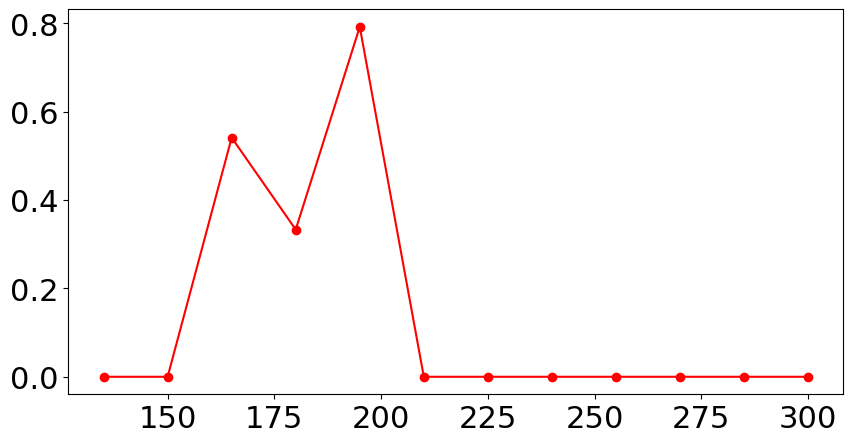

In [21]:
# Extract the distance track
time = df_dists["Time(s)"][(df_dists["NucleusID"]==nuc) & (df_dists["AlleleID"]==allele)]
dist_track = df_dists["MaxDistance(um)"][(df_dists["NucleusID"]==nuc) & (df_dists["AlleleID"]==allele)]
plt.plot(time,dist_track,'-o',color="red")
plt.show()

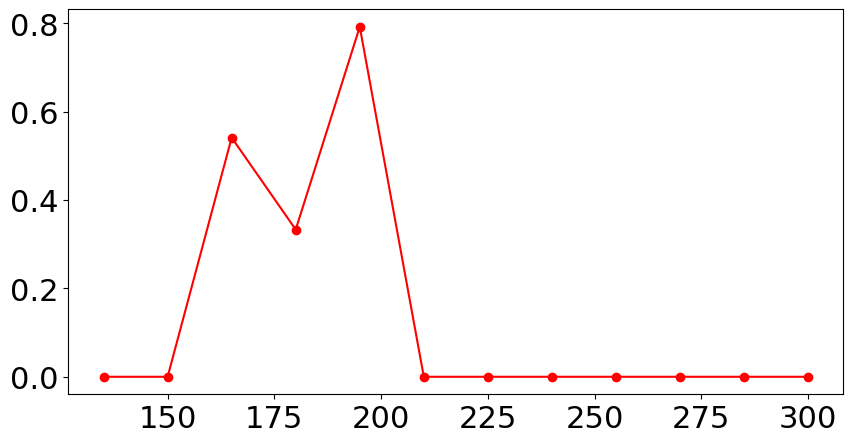

In [22]:
# Calculate distance track filling missing time points
time_filled, dist_track_filled =  calc_dist(df_spots,nuc,allele,mode="max",dt=15,fill_missing_tps=True)
plt.plot(time_filled,dist_track_filled,'-o',color="red")
plt.show()

In [23]:
# Extract SpeedMaxDist and TimeCondensedState
speeds = df_speed_tglue["SpeedMax(um/s)"][(df_speed_tglue["NucleusID"]==nuc) & (df_speed_tglue["AlleleID"]==allele)]
dwell_times = df_speed_tglue["TimeCondensedState(s)-ExcludingFlat"][(df_speed_tglue["NucleusID"]==nuc) & (df_speed_tglue["AlleleID"]==allele)]
dwell_times_flat = df_speed_tglue["TimeCondensedState(s)-IncludingFlat"][(df_speed_tglue["NucleusID"]==nuc) & (df_speed_tglue["AlleleID"]==allele)]

print("SpeedMaxDist:")
print(speeds.values)
print("TimeCondensedState(s)-ExcludingFlat:")
print(dwell_times.values)
print("TimeCondensedState(s)-IncludingFlat:")
print(dwell_times_flat.values)

SpeedMaxDist:
[list([0.052838387139989])]
TimeCondensedState(s)-ExcludingFlat:
[list([105])]
TimeCondensedState(s)-IncludingFlat:
[list([30, 105])]


In [24]:
# Calculate TimeCondensedState including the first dwell time
dwell_times_test1 = mir430_dwell_times(dist_track_filled,mode="glue",from_max=True,dt=15,exclude_first_tglue=True,exclude_flat=True)
print(dwell_times_test1)

[105]


In [25]:
# Calculate TimeCondensedState including the first dwell time
dwell_times_test2 = mir430_dwell_times(dist_track_filled,mode="glue",from_max=True,dt=15,exclude_first_tglue=False,exclude_flat=False)
print(dwell_times_test2)

[30, 105]


In [26]:
# Calculate number of oscillations
n_oscill = n_times_together([dist_track_filled])
print(n_oscill)

[1]


# 4. Observe data

## 4.1 Summary statistics - all stages

In [27]:
# Create dictionary with all relevant data for statustical tests
dict_nanog = {}
dict_no_nanog = {}

keys = ["Time(s)","MaxDist(um)","Oscillations","BaryDist(um)","TimeComeTogether-FromMax(s)","TimeCondensedState(s)-ExcludingFlat","TimeCondensedState(s)-IncludingFlat","SpeedMax(um/s)","SpeedBary(um/s)"]

for stage in (["All stages"] + list(pd.unique(df_spots['Stage']))):
    dict_nanog[stage] = {key:[] for key in keys}
    dict_no_nanog[stage] = {key:[] for key in keys}

In [28]:
# Initialize summary table
summary_table = pd.DataFrame(columns = ['Condition', 'Stage', 'Tracks always sticked', 'Tracks always separated','Average number of oscillations','Average number of oscillations - excluding flat lines','Prob(attach|detached)','Prob(detach|attached)','Average barycentral distance in unbound state(µm)',
                                        'Average speed to come together bary distance (µm/s)', 'Average maximum distance in unound state (µm)', 'Average speed to come together max distance (µm/s)', 
                                        'Average time to come together from max. (s)', 'Average time sticked (s)', 'Average time sticked - excluding flat lines (s)'])

for stage in (["All stages"] + list(pd.unique(df_spots['Stage']))):

  # Select the given stage, distinguish between Nanog and No Nanog nuclei
  if "All stages" != stage:
    df = df_spots[df_spots['Stage']==stage]
  else: 
    df = df_spots

  df_grouped = df[['NucleusID','Nanog']].groupby("NucleusID").agg(pd.unique).reset_index()
  nuclei_nanog = df_grouped['NucleusID'][df_grouped['Nanog']==1]
  nuclei_no_nanog = df_grouped['NucleusID'][df_grouped['Nanog']==0]

  alleles_nanog_from_df = df_nuc_allele[df_nuc_allele['NucleusID'].isin(nuclei_nanog)]['AlleleID']
  alleles_no_nanog_from_df = df_nuc_allele[df_nuc_allele['NucleusID'].isin(nuclei_no_nanog)]['AlleleID']

  alleles_nanog = []
  for i in alleles_nanog_from_df:
      if type(i) == int:
          alleles_nanog.append([i])
      else:
          alleles_nanog.append(list(i))
  
  alleles_no_nanog = []
  for i in alleles_no_nanog_from_df:
      if type(i) == int:
          alleles_no_nanog.append([i])
      else:
          alleles_no_nanog.append(list(i))

  nuclei_nanog = list(nuclei_nanog)
  nuclei_no_nanog = list(nuclei_no_nanog)

  #########################################
  # Barycentral metric
  #########################################

  # Calculate distances with barycentral metric
  dist_nanog_bary = [calc_dist(df_spots,nuclei_nanog[i],alleles_nanog[i][j],"bary")[1] for i in range(len(nuclei_nanog)) for j in range(len(alleles_nanog[i]))]
  dist_no_nanog_bary = [calc_dist(df_spots,nuclei_no_nanog[i],alleles_no_nanog[i][j],"bary")[1] for i in range(len(nuclei_no_nanog)) for j in range(len(alleles_no_nanog[i]))]
  
  # Calculate a few statistics (independent of metric)
  cnt_nanog = count_tracks_sticked(dist_nanog_bary)
  cnt_no_nanog = count_tracks_sticked(dist_no_nanog_bary)

  cnt_nanog_sep = count_tracks_separated(dist_nanog_bary)
  cnt_no_nanog_sep = count_tracks_separated(dist_no_nanog_bary)

  avg_nanog = avg_times_together(dist_nanog_bary)
  avg_no_nanog = avg_times_together(dist_no_nanog_bary)

  n_oscillations_nanog = n_times_together(dist_nanog_bary)
  n_oscillations_no_nanog = n_times_together(dist_no_nanog_bary)

  avg_nanog_excl_flat = avg_times_together(dist_nanog_bary,exclude_flat=True)
  avg_no_nanog_excl_flat = avg_times_together(dist_no_nanog_bary,exclude_flat=True)

  p_a_given_d_nanog = prob_attach_once_detached(dist_nanog_bary,reverse=False)
  p_d_given_a_nanog = prob_attach_once_detached(dist_nanog_bary,reverse=True)
  p_a_given_d_no_nanog = prob_attach_once_detached(dist_no_nanog_bary,reverse=False)
  p_d_given_a_no_nanog = prob_attach_once_detached(dist_no_nanog_bary,reverse=True)

  # Calculate timescales for coming together from maximum distance
  tau_nanog = flatten_list([mir430_dwell_times(dist,mode="motor",dt=15,from_max=True) for dist in dist_nanog_bary])
  tau_no_nanog = flatten_list([mir430_dwell_times(dist,mode="motor",dt=15,from_max=True) for dist in dist_no_nanog_bary])

  # Clculate time sticked
  tau_stick_nanog = flatten_list([mir430_dwell_times(dist,mode="glue",dt=15,exclude_flat=False) for dist in dist_nanog_bary])
  tau_stick_no_nanog = flatten_list([mir430_dwell_times(dist,mode="glue",dt=15,exclude_flat=False) for dist in dist_no_nanog_bary])

  # Clculate time sticked excluding flat lines
  tau_stick_nanog_flat_excl = flatten_list([mir430_dwell_times(dist,mode="glue",dt=15,exclude_flat=True) for dist in dist_nanog_bary])
  tau_stick_no_nanog_flat_excl = flatten_list([mir430_dwell_times(dist,mode="glue",dt=15,exclude_flat=True) for dist in dist_no_nanog_bary])

  # calculate velocities
  v_nanog_bary = flatten_list([mir430_speeds(dist,dt=15) for dist in dist_nanog_bary])
  v_no_nanog_bary = flatten_list([mir430_speeds(dist,dt=15) for dist in dist_no_nanog_bary])

  # Study distances when foci are unbound
  dist_unbound_nanog_bary = np.array([i for item in dist_nanog_bary for i in item])
  dist_unbound_nanog_bary = dist_unbound_nanog_bary[dist_unbound_nanog_bary>0]

  dist_unbound_no_nanog_bary = np.array([i for item in dist_no_nanog_bary for i in item])
  dist_unbound_no_nanog_bary = dist_unbound_no_nanog_bary[dist_unbound_no_nanog_bary>0]

  #########################################
  # Maximum metric
  #########################################

  # Calculate distances with maximum distance metric
  dist_nanog_max = [calc_dist(df_spots,nuclei_nanog[i],alleles_nanog[i][j],"max")[1] for i in range(len(nuclei_nanog)) for j in range(len(alleles_nanog[i]))]
  dist_no_nanog_max = [calc_dist(df_spots,nuclei_no_nanog[i],alleles_no_nanog[i][j],"max")[1] for i in range(len(nuclei_no_nanog)) for j in range(len(alleles_no_nanog[i]))]

  # Calculate time
  time_nanog = [calc_dist(df_spots,nuclei_nanog[i],alleles_nanog[i][j],"max")[0] for i in range(len(nuclei_nanog)) for j in range(len(alleles_nanog[i]))]
  time_no_nanog = [calc_dist(df_spots,nuclei_no_nanog[i],alleles_no_nanog[i][j],"max")[0] for i in range(len(nuclei_no_nanog)) for j in range(len(alleles_no_nanog[i]))]

  # calculate velocities
  v_nanog_max = flatten_list([mir430_speeds(dist,dt=15) for dist in dist_nanog_max])
  v_no_nanog_max = flatten_list([mir430_speeds(dist,dt=15) for dist in dist_no_nanog_max])

  # Study distances when foci are unbound
  dist_unbound_nanog_max = np.array([i for item in dist_nanog_max for i in item])
  dist_unbound_nanog_max = dist_unbound_nanog_max[dist_unbound_nanog_max>0]

  dist_unbound_no_nanog_max = np.array([i for item in dist_no_nanog_max for i in item])
  dist_unbound_no_nanog_max = dist_unbound_no_nanog_max[dist_unbound_no_nanog_max>0]


  # Add values to dictionary
  dict_nanog[stage]["BaryDist(um)"] = dist_nanog_bary
  dict_no_nanog[stage]["BaryDist(um)"] = dist_no_nanog_bary
  dict_nanog[stage]["MaxDist(um)"] = dist_nanog_max
  dict_no_nanog[stage]["MaxDist(um)"] = dist_no_nanog_max
  dict_nanog[stage]["Time(s)"] = time_nanog
  dict_no_nanog[stage]["Time(s)"] = time_no_nanog
  dict_nanog[stage]["Oscillations"] = n_oscillations_nanog
  dict_no_nanog[stage]["Oscillations"] = n_oscillations_no_nanog
  dict_nanog[stage]["TimeComeTogether-FromMax(s)"] = tau_nanog
  dict_no_nanog[stage]["TimeComeTogether-FromMax(s)"] = tau_no_nanog
  dict_nanog[stage]["TimeCondensedState(s)-ExcludingFlat"] = tau_stick_nanog_flat_excl 
  dict_no_nanog[stage]["TimeCondensedState(s)-ExcludingFlat"] = tau_stick_no_nanog_flat_excl 
  dict_nanog[stage]["TimeCondensedState(s)-IncludingFlat"] = tau_stick_nanog 
  dict_no_nanog[stage]["TimeCondensedState(s)-IncludingFlat"] = tau_stick_no_nanog 
  dict_nanog[stage]["SpeedMax(um/s)"] = v_nanog_max 
  dict_no_nanog[stage]["SpeedMax(um/s)"] = v_no_nanog_max 
  dict_nanog[stage]["SpeedBary(um/s)"] =  v_nanog_bary 
  dict_no_nanog[stage]["SpeedBary(um/s)"] = v_no_nanog_bary 


  #Add values to summary table
  summary_table = summary_table.append({'Condition' : 'Nanog', 'Stage' : stage, 'Tracks always sticked':cnt_nanog, 'Tracks always separated':cnt_nanog_sep,'Average number of oscillations':avg_nanog,'Average number of oscillations - excluding flat lines':avg_nanog_excl_flat,'Prob(attach|detached)':np.nanmean(p_a_given_d_nanog),'Prob(detach|attached)':np.nanmean(p_d_given_a_nanog),'Average barycentral distance in unbound state(µm)':np.mean(dist_unbound_nanog_bary),
                                        'Average speed to come together bary distance (µm/s)':np.mean(v_nanog_bary), 'Average maximum distance in unound state (µm)':np.mean(dist_unbound_nanog_max), 'Average speed to come together max distance (µm/s)':np.mean(v_nanog_max), 
                                        'Average time to come together from max. (s)':np.mean(tau_nanog), 'Average time sticked (s)':np.mean(tau_stick_nanog), 'Average time sticked - excluding flat lines (s)':np.mean(tau_stick_nanog_flat_excl)}, ignore_index = True)
  summary_table = summary_table.append({'Condition' : 'No Nanog', 'Stage' : stage, 'Tracks always sticked':cnt_no_nanog, 'Tracks always separated':cnt_no_nanog_sep,'Average number of oscillations':avg_no_nanog,'Average number of oscillations - excluding flat lines':avg_no_nanog_excl_flat,'Prob(attach|detached)':np.nanmean(p_a_given_d_no_nanog),'Prob(detach|attached)':np.nanmean(p_d_given_a_no_nanog),'Average barycentral distance in unbound state(µm)':np.mean(dist_unbound_no_nanog_bary),
                                        'Average speed to come together bary distance (µm/s)':np.mean(v_no_nanog_bary), 'Average maximum distance in unound state (µm)':np.mean(dist_unbound_no_nanog_max), 'Average speed to come together max distance (µm/s)':np.mean(v_no_nanog_max), 
                                        'Average time to come together from max. (s)':np.mean(tau_no_nanog), 'Average time sticked (s)':np.mean(tau_stick_no_nanog), 'Average time sticked - excluding flat lines (s)':np.mean(tau_stick_no_nanog_flat_excl)}, ignore_index = True)
  
summary_table

/home/alessia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: Mean of empty slice
/home/alessia/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alessia/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Condition,Stage,Tracks always sticked,Tracks always separated,Average number of oscillations,Average number of oscillations - excluding flat lines,Prob(attach|detached),Prob(detach|attached),Average barycentral distance in unbound state(µm),Average speed to come together bary distance (µm/s),Average maximum distance in unound state (µm),Average speed to come together max distance (µm/s),Average time to come together from max. (s),Average time sticked (s),Average time sticked - excluding flat lines (s)
0,Nanog,All stages,0.304878,0.012195,1.317073,1.894737,0.904386,0.436096,0.813800,0.045758,0.780589,0.044293,19.450549,107.180233,83.472222
1,No Nanog,All stages,0.185185,0.012346,1.876543,2.30303,0.871465,0.588527,0.995324,0.050976,0.928766,0.047298,23.507463,74.509346,54.078947
2,Nanog,1k,0.340909,0.022727,1.068182,1.62069,0.885057,0.375194,0.804097,0.044550,0.790213,0.044082,18.846154,123.475610,100.851064
3,No Nanog,1k,0.170732,0.02439,2.097561,2.529412,0.919118,0.579970,1.031297,0.050381,0.955253,0.046359,21.818182,71.410256,49.360465
4,Nanog,512,0.230769,0.0,1.230769,1.6,0.950000,0.435897,0.746844,0.043336,0.731006,0.043336,17.307692,120.000000,113.437500
5,No Nanog,512,0.090909,0.0,2.090909,2.3,0.755000,0.754545,0.802583,0.059009,0.743729,0.052863,20.714286,50.625000,47.608696
6,Nanog,High,0.125,0.0,1.625,1.857143,0.852381,0.656250,0.794779,0.045523,0.765706,0.039920,17.500000,71.250000,57.692308
7,No Nanog,High,0.222222,0.0,1.555556,2.0,0.843651,0.558642,1.018273,0.048092,0.963238,0.046547,29.142857,86.854839,65.714286
8,Nanog,256,0.5,0.0,1.125,2.25,1.000000,0.322917,0.856564,0.030436,0.738411,0.029400,26.250000,127.500000,61.666667
9,No Nanog,256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Save summary table
summary_table.to_csv(today+"-miR430-summary_stats.csv",index=True,sep='\t')

## 4.2 Plot trajectories - choose a stage and a distance metric

In [30]:
# Select stage
stage = "1k"

# Select distance metric
dist_metric = "BaryDist(um)" # "MaxDist(um)"

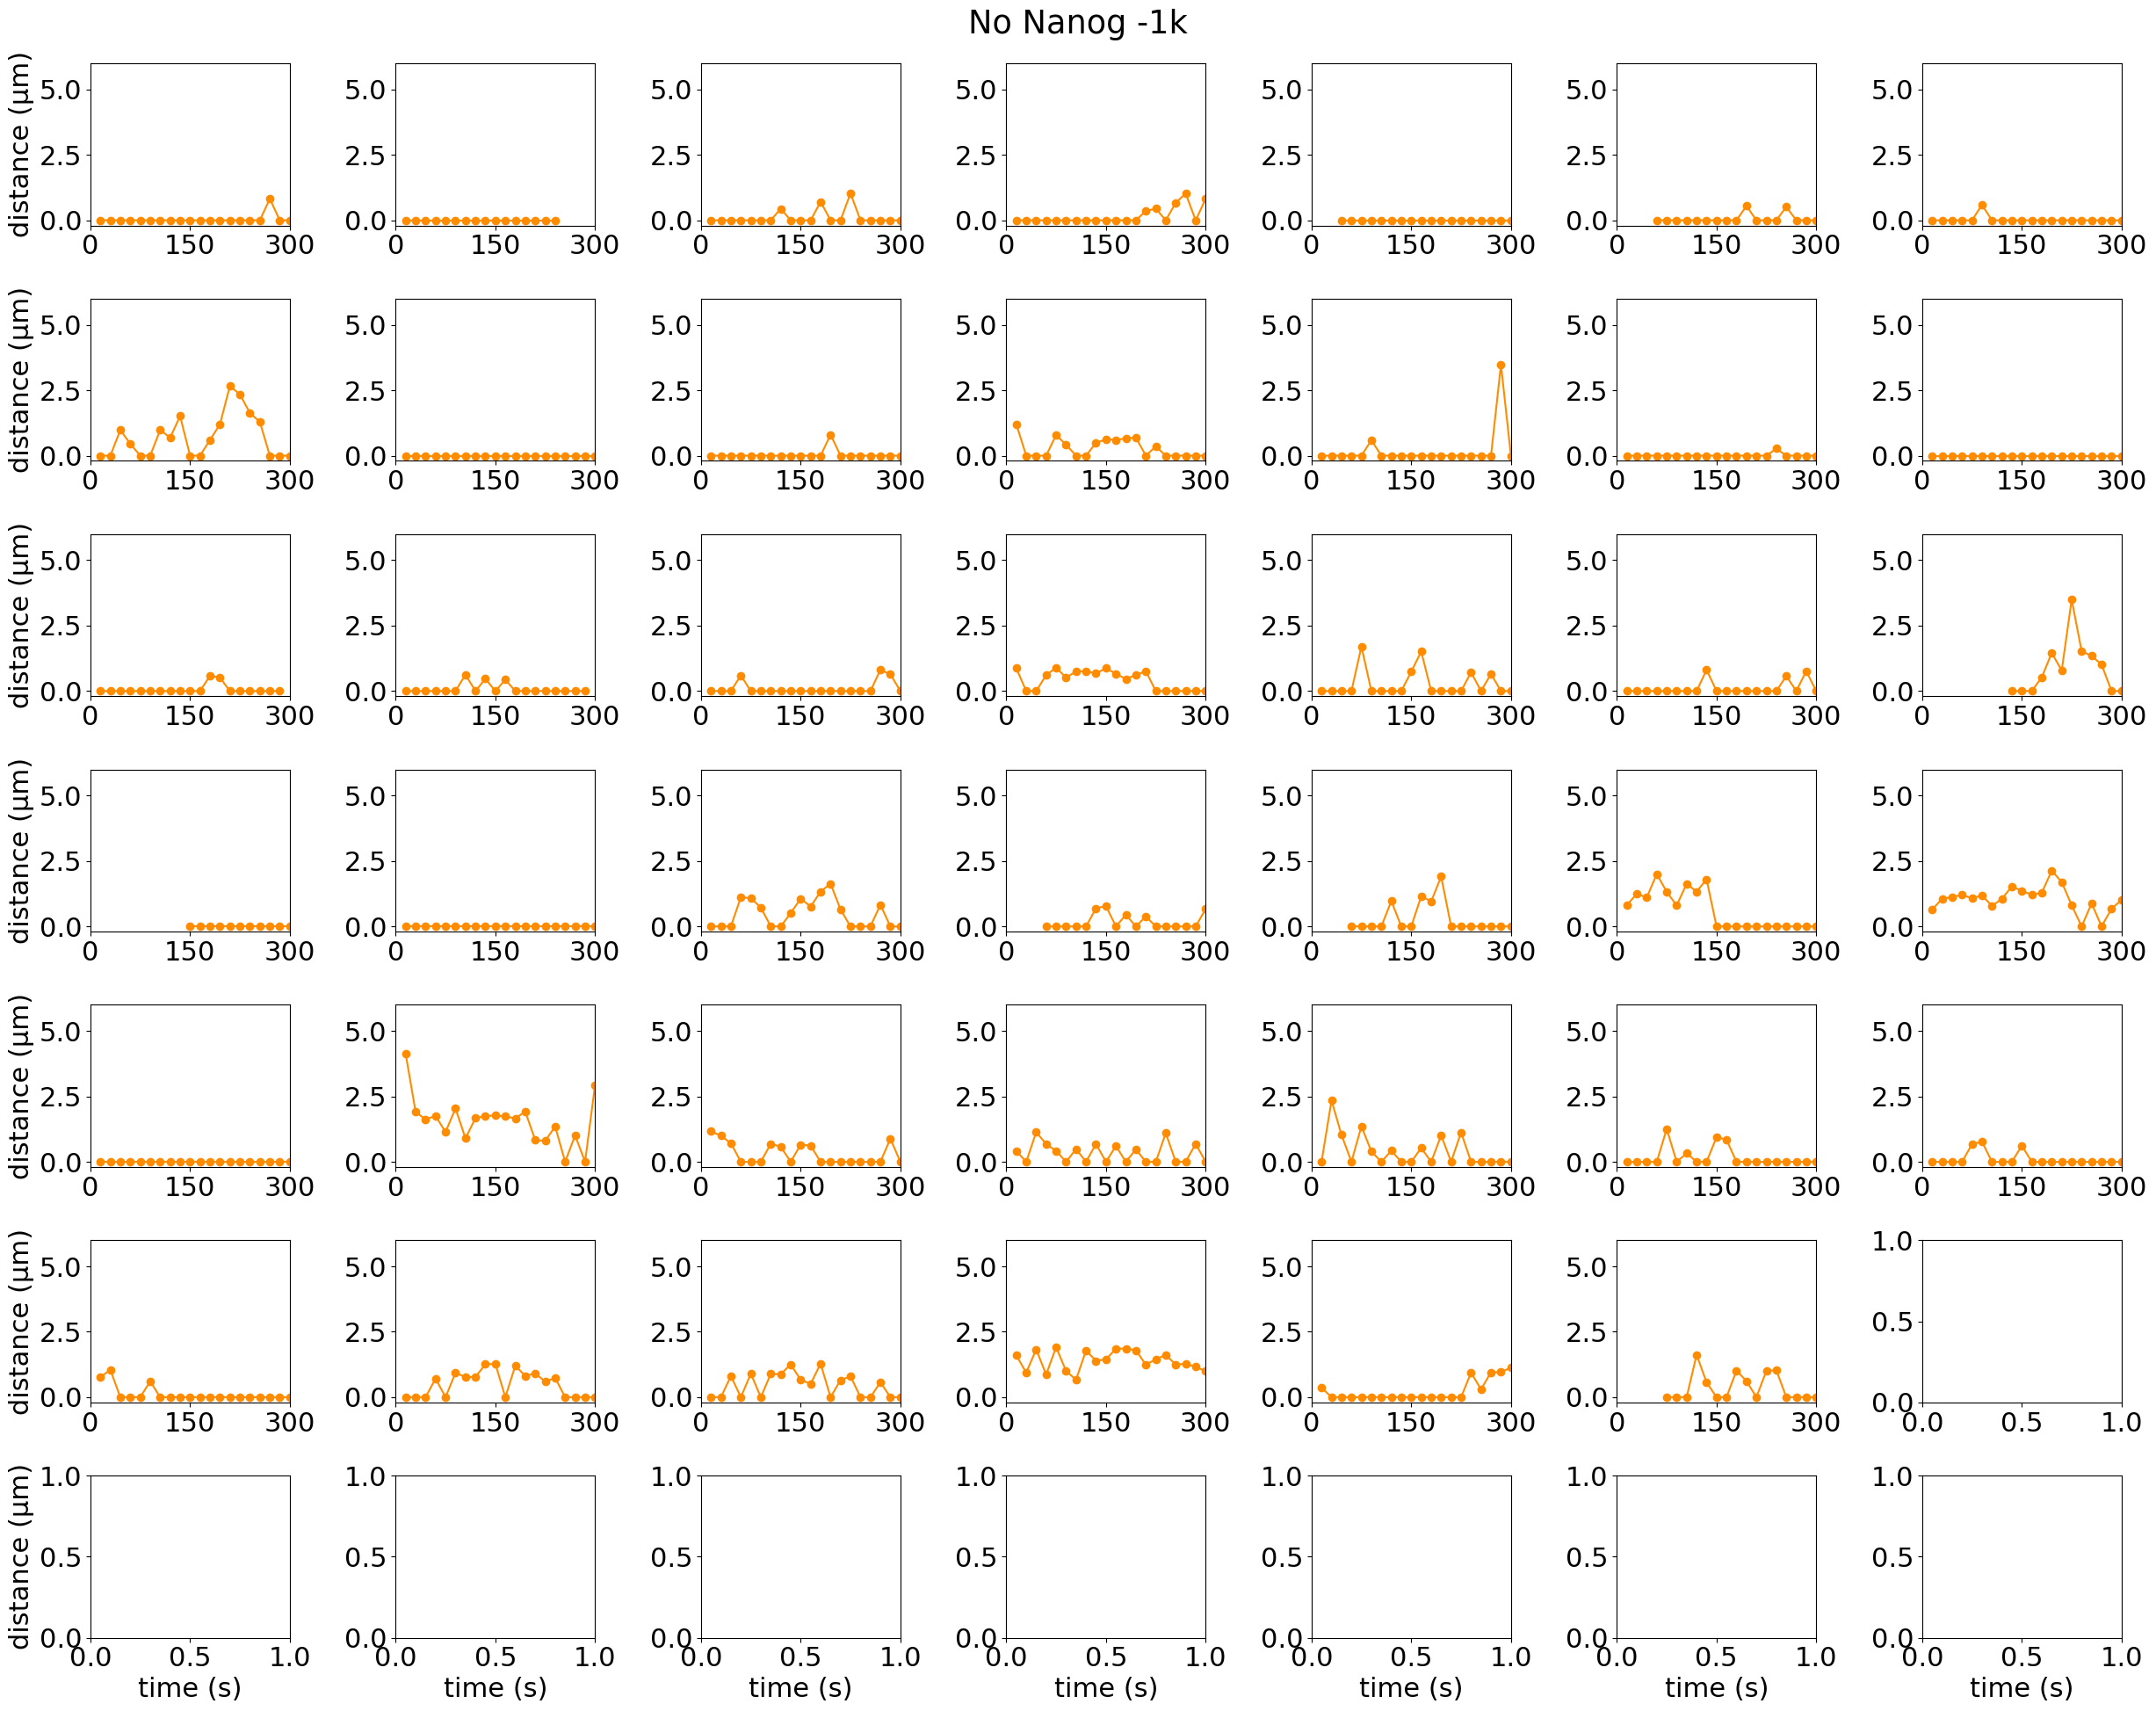

In [31]:
# Plot No Nanog
grid_size = 1
while grid_size*grid_size < len(dict_no_nanog[stage]["Time(s)"]):
    grid_size = grid_size+1

fig, ax = plt.subplots(ncols=grid_size,nrows=grid_size,figsize=(25,20))

for i in range(min(grid_size*grid_size,len(dict_no_nanog[stage]["Time(s)"]))):
    ax[int(i/grid_size),i%grid_size].plot(dict_no_nanog[stage]["Time(s)"][i],dict_no_nanog[stage][dist_metric][i],'-o',color="darkorange") 
    ax[int(i/grid_size),i%grid_size].set_ylim(-0.2,6)
    ax[int(i/grid_size),i%grid_size].set_xlim(0,300)
    ax[int(i/grid_size),i%grid_size].set_xticks([0,150,300])


for i in range(grid_size):
    ax[grid_size-1,i].set_xlabel('time (s)')
    ax[i,0].set_ylabel('distance (µm)')

plt.suptitle("No Nanog -%s"%stage)
plt.tight_layout()
plt.show()

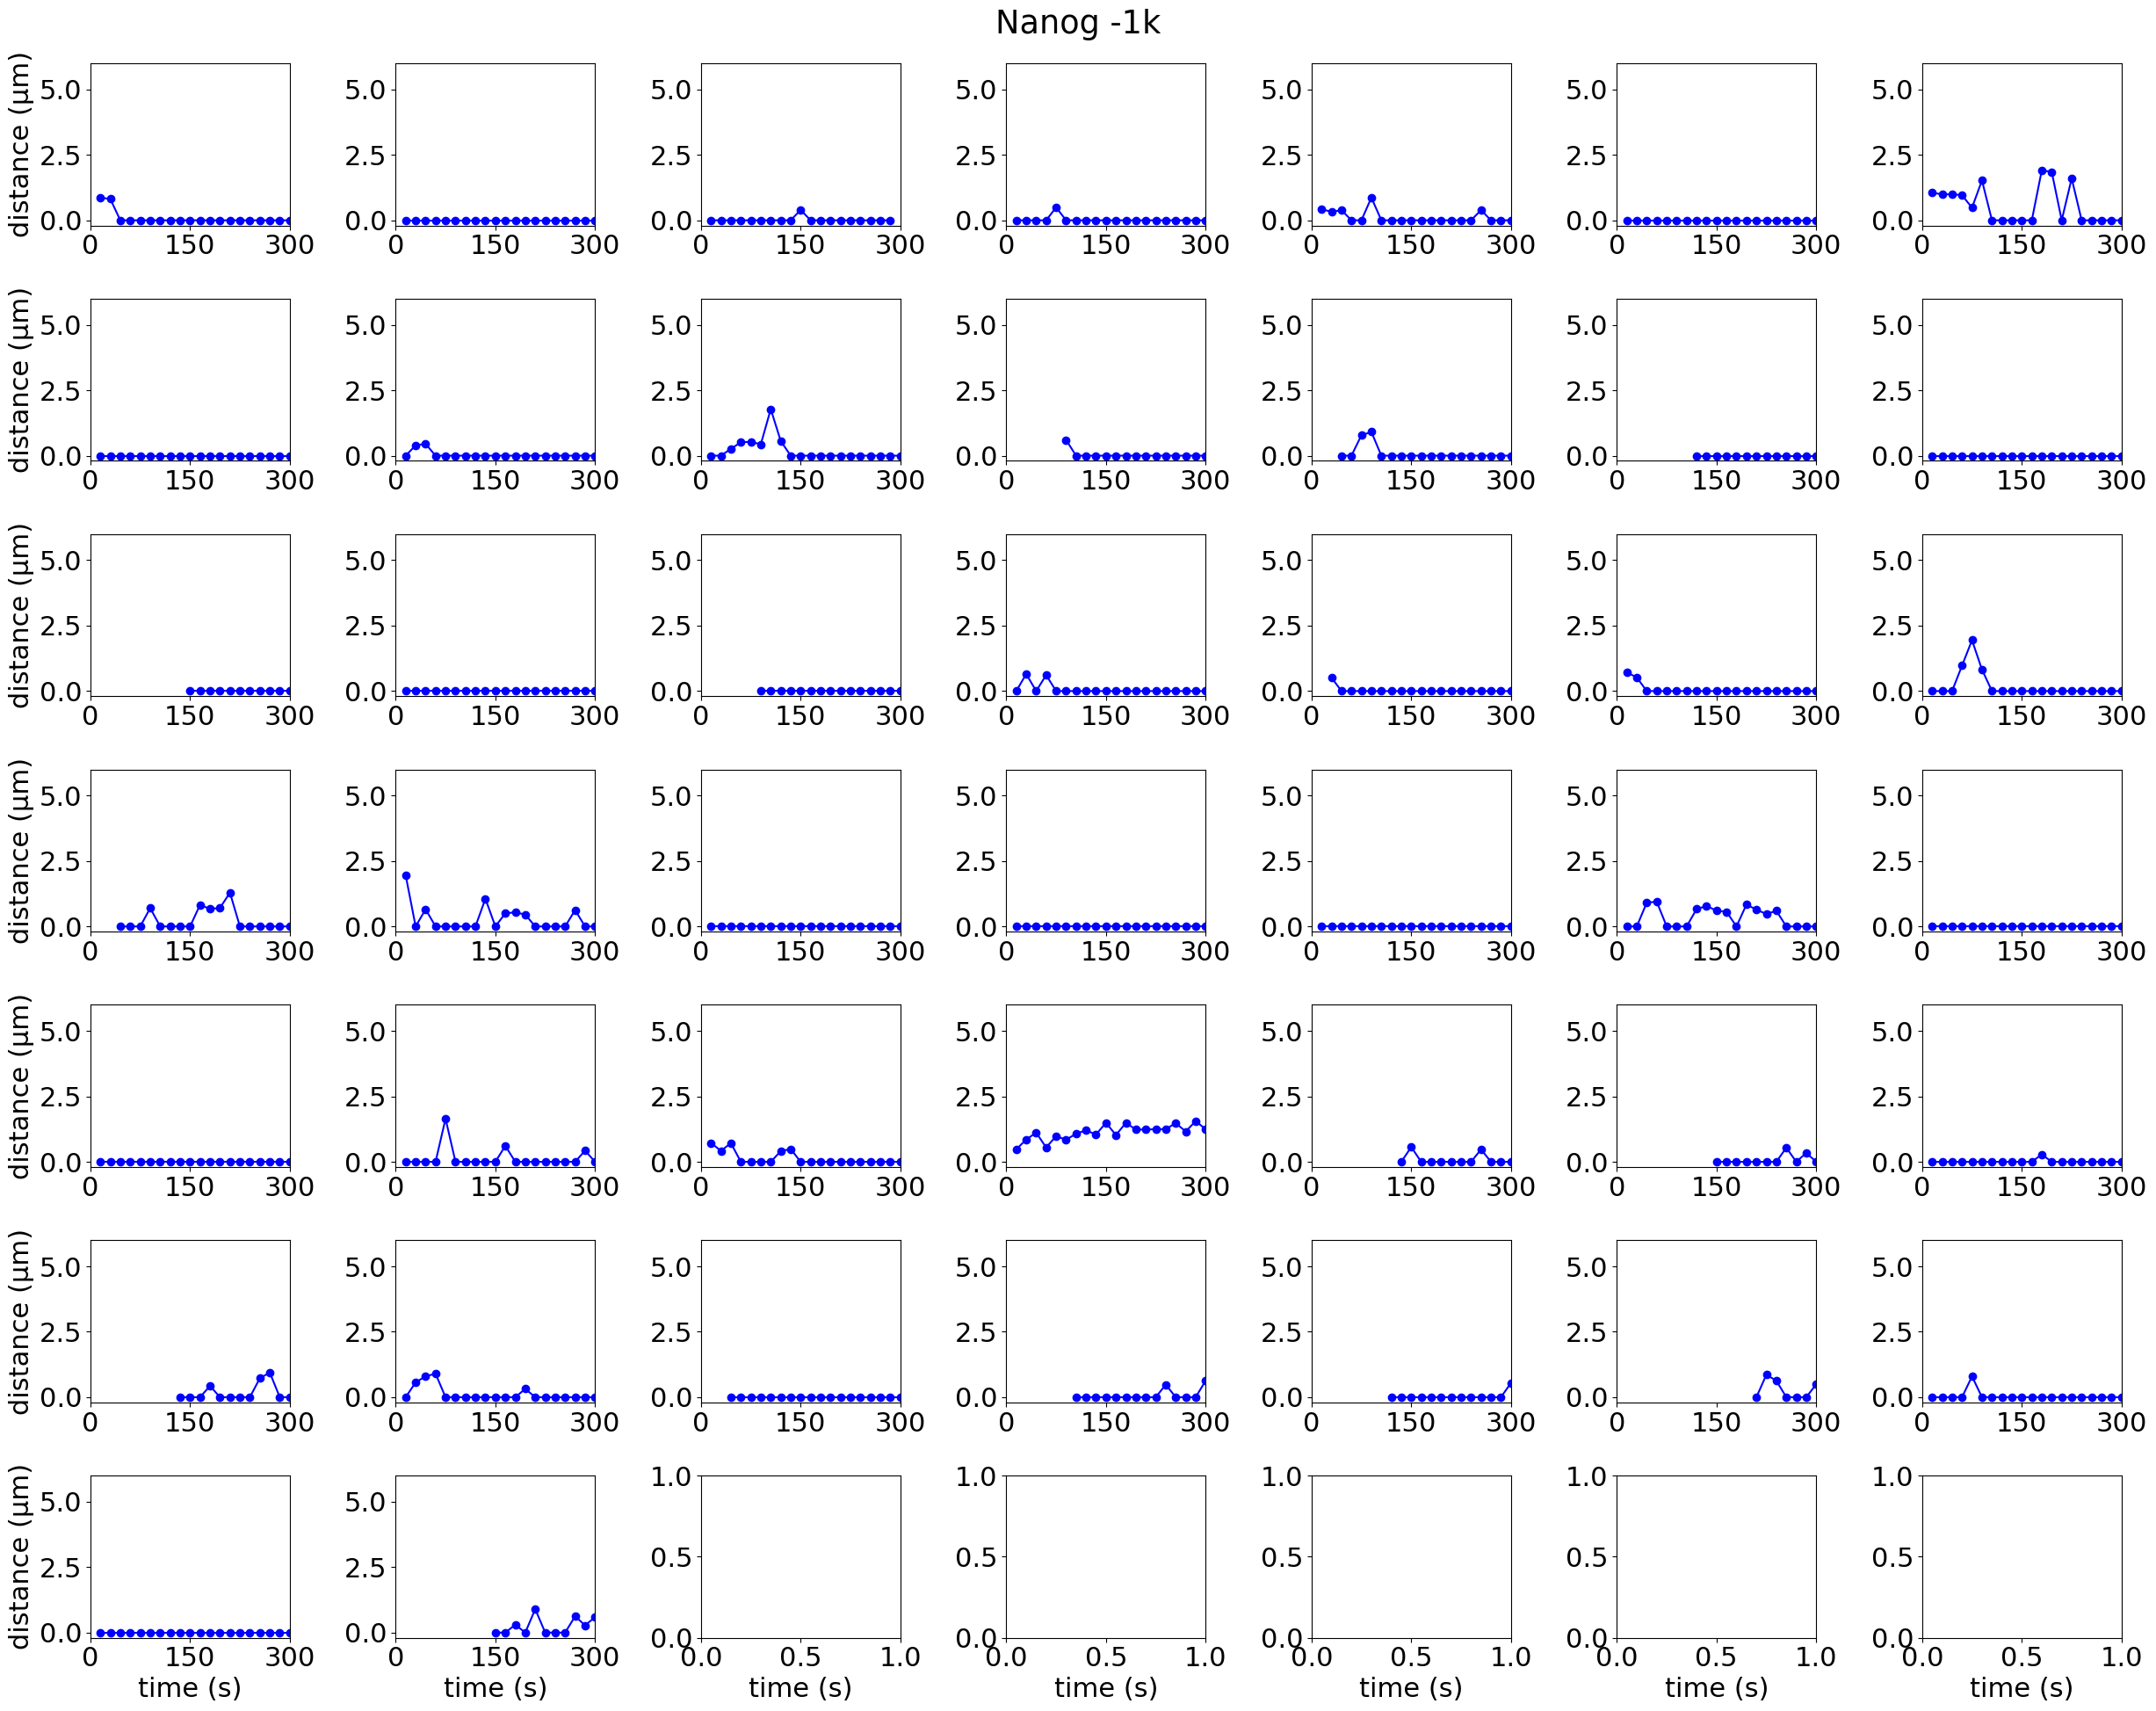

In [32]:
# Plot Nanog
grid_size = 1
while grid_size*grid_size < len(dict_nanog[stage]["Time(s)"]):
    grid_size = grid_size+1

fig, ax = plt.subplots(ncols=grid_size,nrows=grid_size,figsize=(25,20))

for i in range(min(grid_size*grid_size,len(dict_nanog[stage]["Time(s)"]))):
    ax[int(i/grid_size),i%grid_size].plot(dict_nanog[stage]["Time(s)"][i],dict_nanog[stage][dist_metric][i],'-o',color="blue") 
    ax[int(i/grid_size),i%grid_size].set_ylim(-0.2,6)
    ax[int(i/grid_size),i%grid_size].set_xlim(0,300)
    ax[int(i/grid_size),i%grid_size].set_xticks([0,150,300])


for i in range(grid_size):
    ax[grid_size-1,i].set_xlabel('time (s)')
    ax[i,0].set_ylabel('distance (µm)')

plt.suptitle("Nanog -%s"%stage)
plt.tight_layout()
plt.show()

# 5. Hypothesis testing

In [33]:
# Choose stage and metric
stages_to_check = ["All stages", "1k"]
dist_metrics_to_check = ["BaryDist(um)", "MaxDist(um)"]
speed_metrics_to_check = ["SpeedBary(um/s)", "SpeedMax(um/s)"]

In [34]:
stats_table = pd.DataFrame(columns = ['Measure', 'Metric' ,'Stage', 'p-value'])

## 5.1 Number of oscillations

p-value Mann-Whitney U test for stage All stages: 0.025988
p-value Mann-Whitney U test for stage 1k: 0.005275


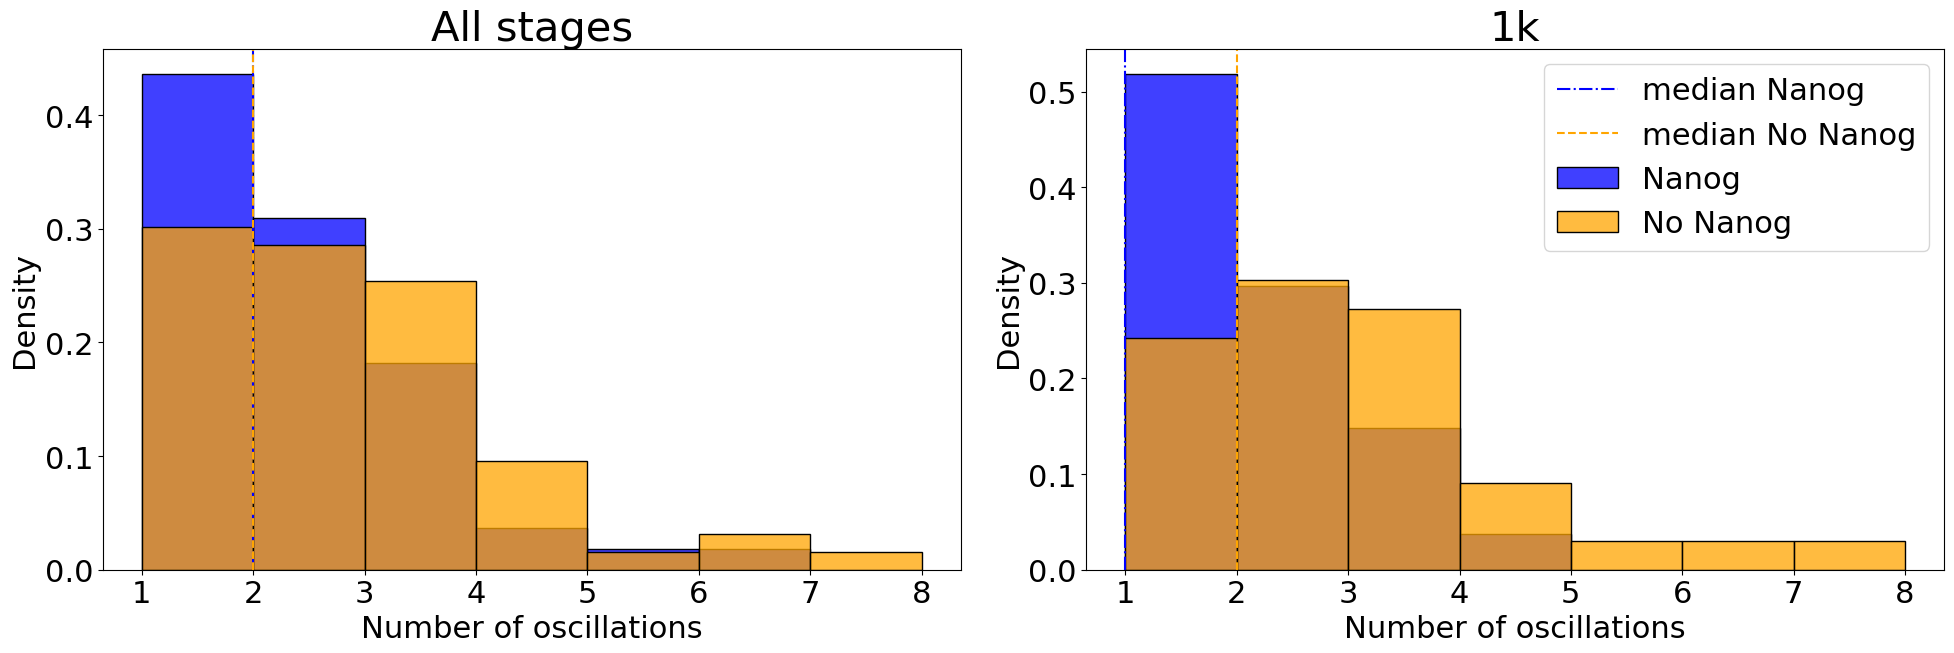

In [35]:
# Histograms of number of oscillations
fig, axs = plt.subplots(ncols=len(stages_to_check),nrows=1,figsize=(10*len(stages_to_check),7))

i = 0
for stage in stages_to_check:

    # Get number of oscillations
    oscill_nanog = dict_nanog[stage]["Oscillations"]
    oscill_no_nanog = dict_no_nanog[stage]["Oscillations"]

    # Hypothesis test
    U1, p_mw = stats.mannwhitneyu(oscill_no_nanog,oscill_nanog,alternative="greater")
    print("p-value Mann-Whitney U test for stage %s: %f"%(stage,p_mw))
    stats_table = stats_table.append({'Measure' : "number of oscillations", 'Metric' : "-" ,'Stage' : stage, 'p-value':p_mw},ignore_index=True)

    # Plot histograms
    axs[i].set_title(stage, fontsize=30)
    sns.histplot(ax=axs[i],data=pd.DataFrame({"nanog":oscill_nanog})["nanog"],stat="density",bins=4,color="blue",label="Nanog",binwidth=1)
    sns.histplot(ax=axs[i],data=pd.DataFrame({"no nanog":oscill_no_nanog})["no nanog"],stat="density",bins=4,color="orange",label = "No Nanog",binwidth=1)
    axs[i].set_xlabel("Number of oscillations")
    axs[i].axvline(x=np.median(oscill_nanog),color="blue",linestyle='-.',label="median Nanog")
    axs[i].axvline(x=np.median(oscill_no_nanog),color="orange",linestyle='--',label="median No Nanog")
    i+=1
axs[i-1].legend()
plt.tight_layout()
plt.show()

## 5.2 Hypothesis test for "motor hypothesis"

### Distances in unbound state

p-value Mann-Whitney U test for stage All stages and metric BaryDist(um): 0.000001
p-value Mann-Whitney U test for stage 1k and metric BaryDist(um): 0.000019
p-value Mann-Whitney U test for stage All stages and metric MaxDist(um): 0.000001
p-value Mann-Whitney U test for stage 1k and metric MaxDist(um): 0.000042


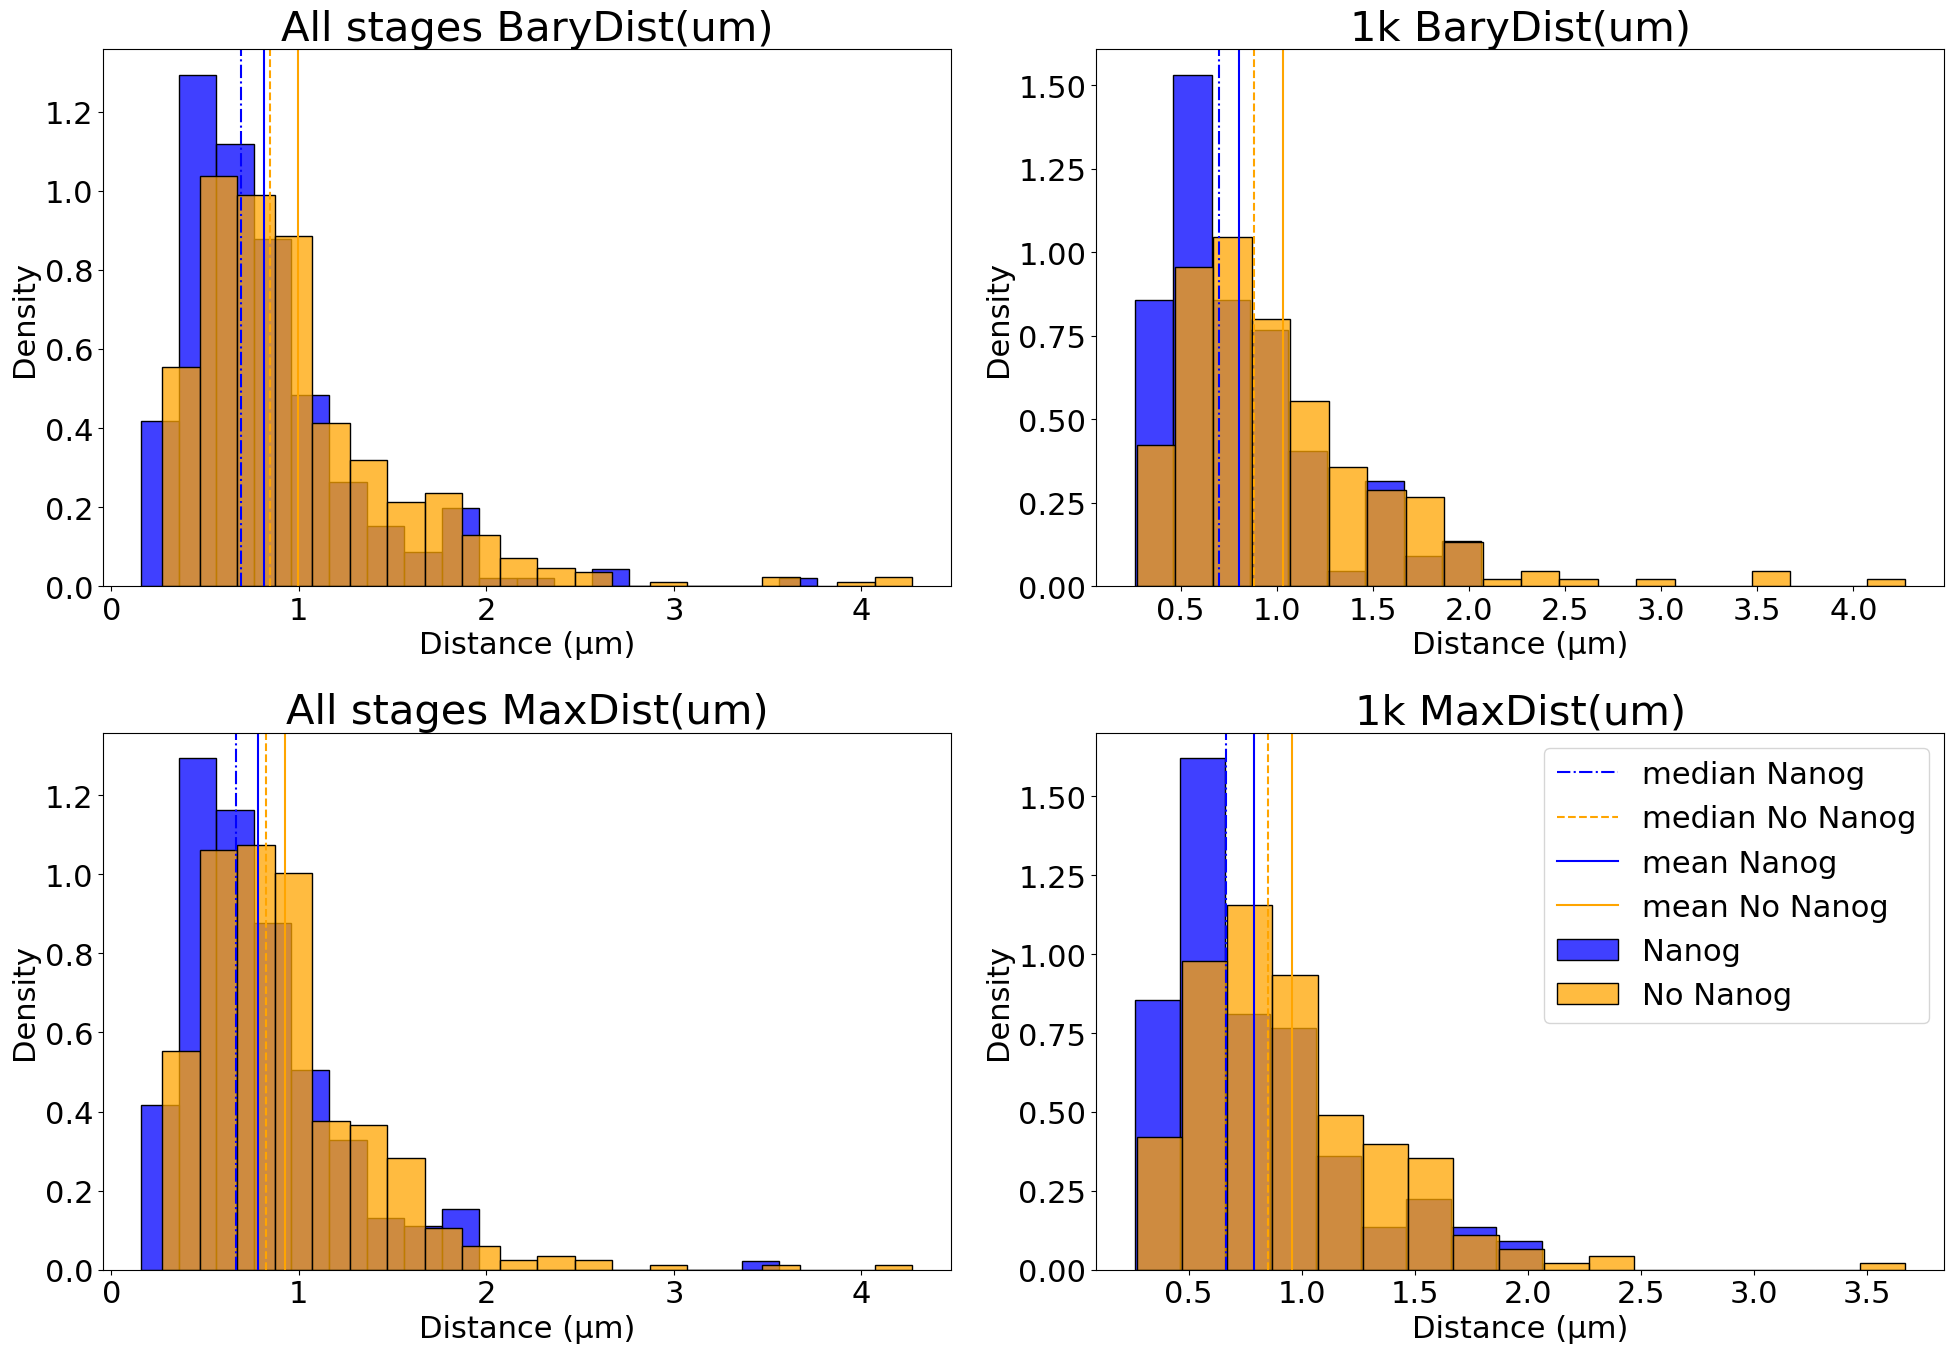

In [36]:
fig, axs = plt.subplots(ncols=len(stages_to_check),nrows=len(dist_metrics_to_check),figsize=(10*len(stages_to_check),7*len(dist_metrics_to_check)))

i = 0
for dist_metric in dist_metrics_to_check:
    j=0
    for stage in stages_to_check:

        # Get distances
        dist_unbound_nanog = flatten_list(dict_nanog[stage][dist_metric])
        dist_unbound_nanog = [dist for dist in dist_unbound_nanog if dist > 0]
        dist_unbound_no_nanog = flatten_list(dict_no_nanog[stage][dist_metric])
        dist_unbound_no_nanog = [dist for dist in dist_unbound_no_nanog if dist > 0]

        # Statistical test
        U1, p_mw = stats.mannwhitneyu(dist_unbound_nanog, dist_unbound_no_nanog, alternative="less")
        print("p-value Mann-Whitney U test for stage %s and metric %s: %f"%(stage,dist_metric,p_mw))
        stats_table = stats_table.append({'Measure' : "distances in unbound state", 'Metric' : dist_metric ,'Stage' : stage, 'p-value':p_mw},ignore_index=True)

        sns.histplot(ax=axs[i,j], data=pd.DataFrame({"nanog":dist_unbound_nanog})["nanog"],stat="density",color="blue",label="Nanog",binwidth=0.2)
        sns.histplot(ax=axs[i,j], data=pd.DataFrame({"no nanog":dist_unbound_no_nanog})["no nanog"],stat="density",color="orange",label = "No Nanog",binwidth=0.2)
        axs[i,j].set_title(stage + " " + dist_metric, fontsize=30)
        axs[i,j].axvline(x=np.median(dist_unbound_nanog),color="blue",linestyle='-.',label="median Nanog")
        axs[i,j].axvline(x=np.median(dist_unbound_no_nanog),color="orange",linestyle='--',label="median No Nanog")
        axs[i,j].axvline(x=np.mean(dist_unbound_nanog),color="blue",linestyle='-',label="mean Nanog")
        axs[i,j].axvline(x=np.mean(dist_unbound_no_nanog),color="orange",linestyle='-',label="mean No Nanog")
        axs[i,j].set_xlabel("Distance (µm)")
        
        j+=1
    axs[i,j-1].set_ylabel("Density")
    i+=1
axs[i-1,j-1].legend()
plt.tight_layout()
plt.show()

### Time to come together from max

p-value Mann-Whitney U test for stage All stages: 0.027697
p-value Mann-Whitney U test for stage 1k: 0.241658


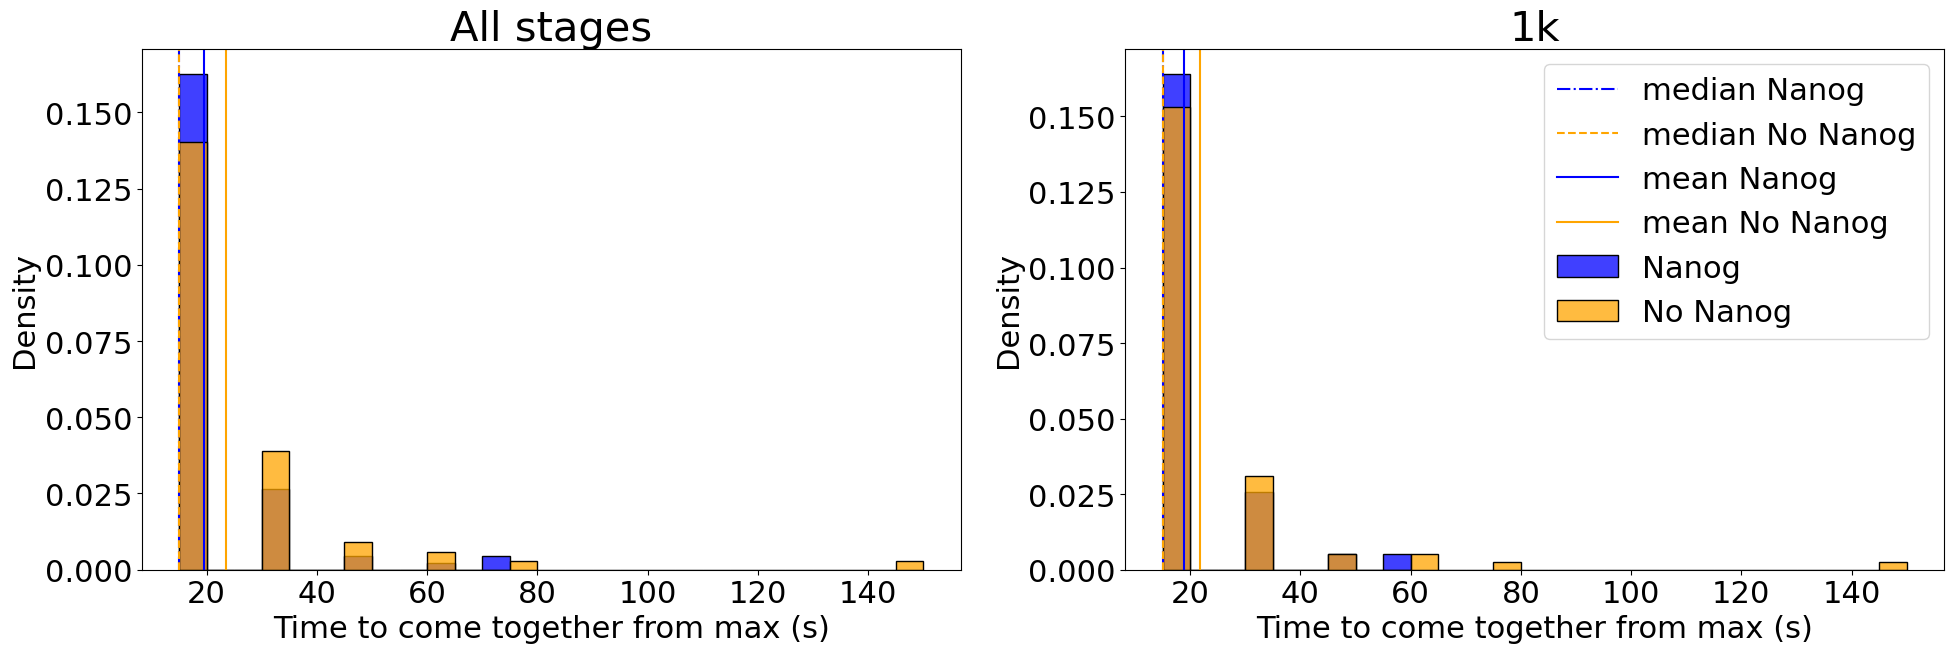

In [37]:
fig, ax = plt.subplots(ncols=len(stages_to_check),nrows=1,figsize=(10*len(stages_to_check),7))

i = 0
for stage in stages_to_check:

    # Get times to come together from max distance
    tau_nanog = dict_nanog[stage]["TimeComeTogether-FromMax(s)"]
    tau_no_nanog = dict_no_nanog[stage]["TimeComeTogether-FromMax(s)"]

    # Statistical test
    U1, p_mw = stats.mannwhitneyu(tau_no_nanog,tau_nanog,alternative="greater")
    print("p-value Mann-Whitney U test for stage %s: %f"%(stage,p_mw))
    stats_table = stats_table.append({'Measure' : "time to come together from max", 'Metric' : "-" ,'Stage' : stage, 'p-value':p_mw},ignore_index=True)

    # Plot histograms
    ax[i].set_title(stage, fontsize=30)
    sns.histplot(ax=ax[i],data=pd.DataFrame({"nanog":tau_nanog})["nanog"],stat="density",color="blue",label="Nanog",binwidth=5)
    sns.histplot(ax=ax[i],data=pd.DataFrame({"no nanog":tau_no_nanog})["no nanog"],stat="density",color="orange",label = "No Nanog",binwidth=5)
    ax[i].set_xlabel("Time to come together from max (s)")
    ax[i].axvline(x=np.median(tau_nanog),color="blue",linestyle='-.',label="median Nanog")
    ax[i].axvline(x=np.median(tau_no_nanog),color="orange",linestyle='--',label="median No Nanog")
    ax[i].axvline(x=np.mean(tau_nanog),color="blue",linestyle='-',label="mean Nanog")
    ax[i].axvline(x=np.mean(tau_no_nanog),color="orange",linestyle='-',label="mean No Nanog")
    i+=1
ax[i-1].legend()
plt.tight_layout()
plt.show()

### Speed to come together from max

p-value Mann-Whitney U test: 0.933103
p-value Mann-Whitney U test: 0.844000
p-value Mann-Whitney U test: 0.865402
p-value Mann-Whitney U test: 0.639264


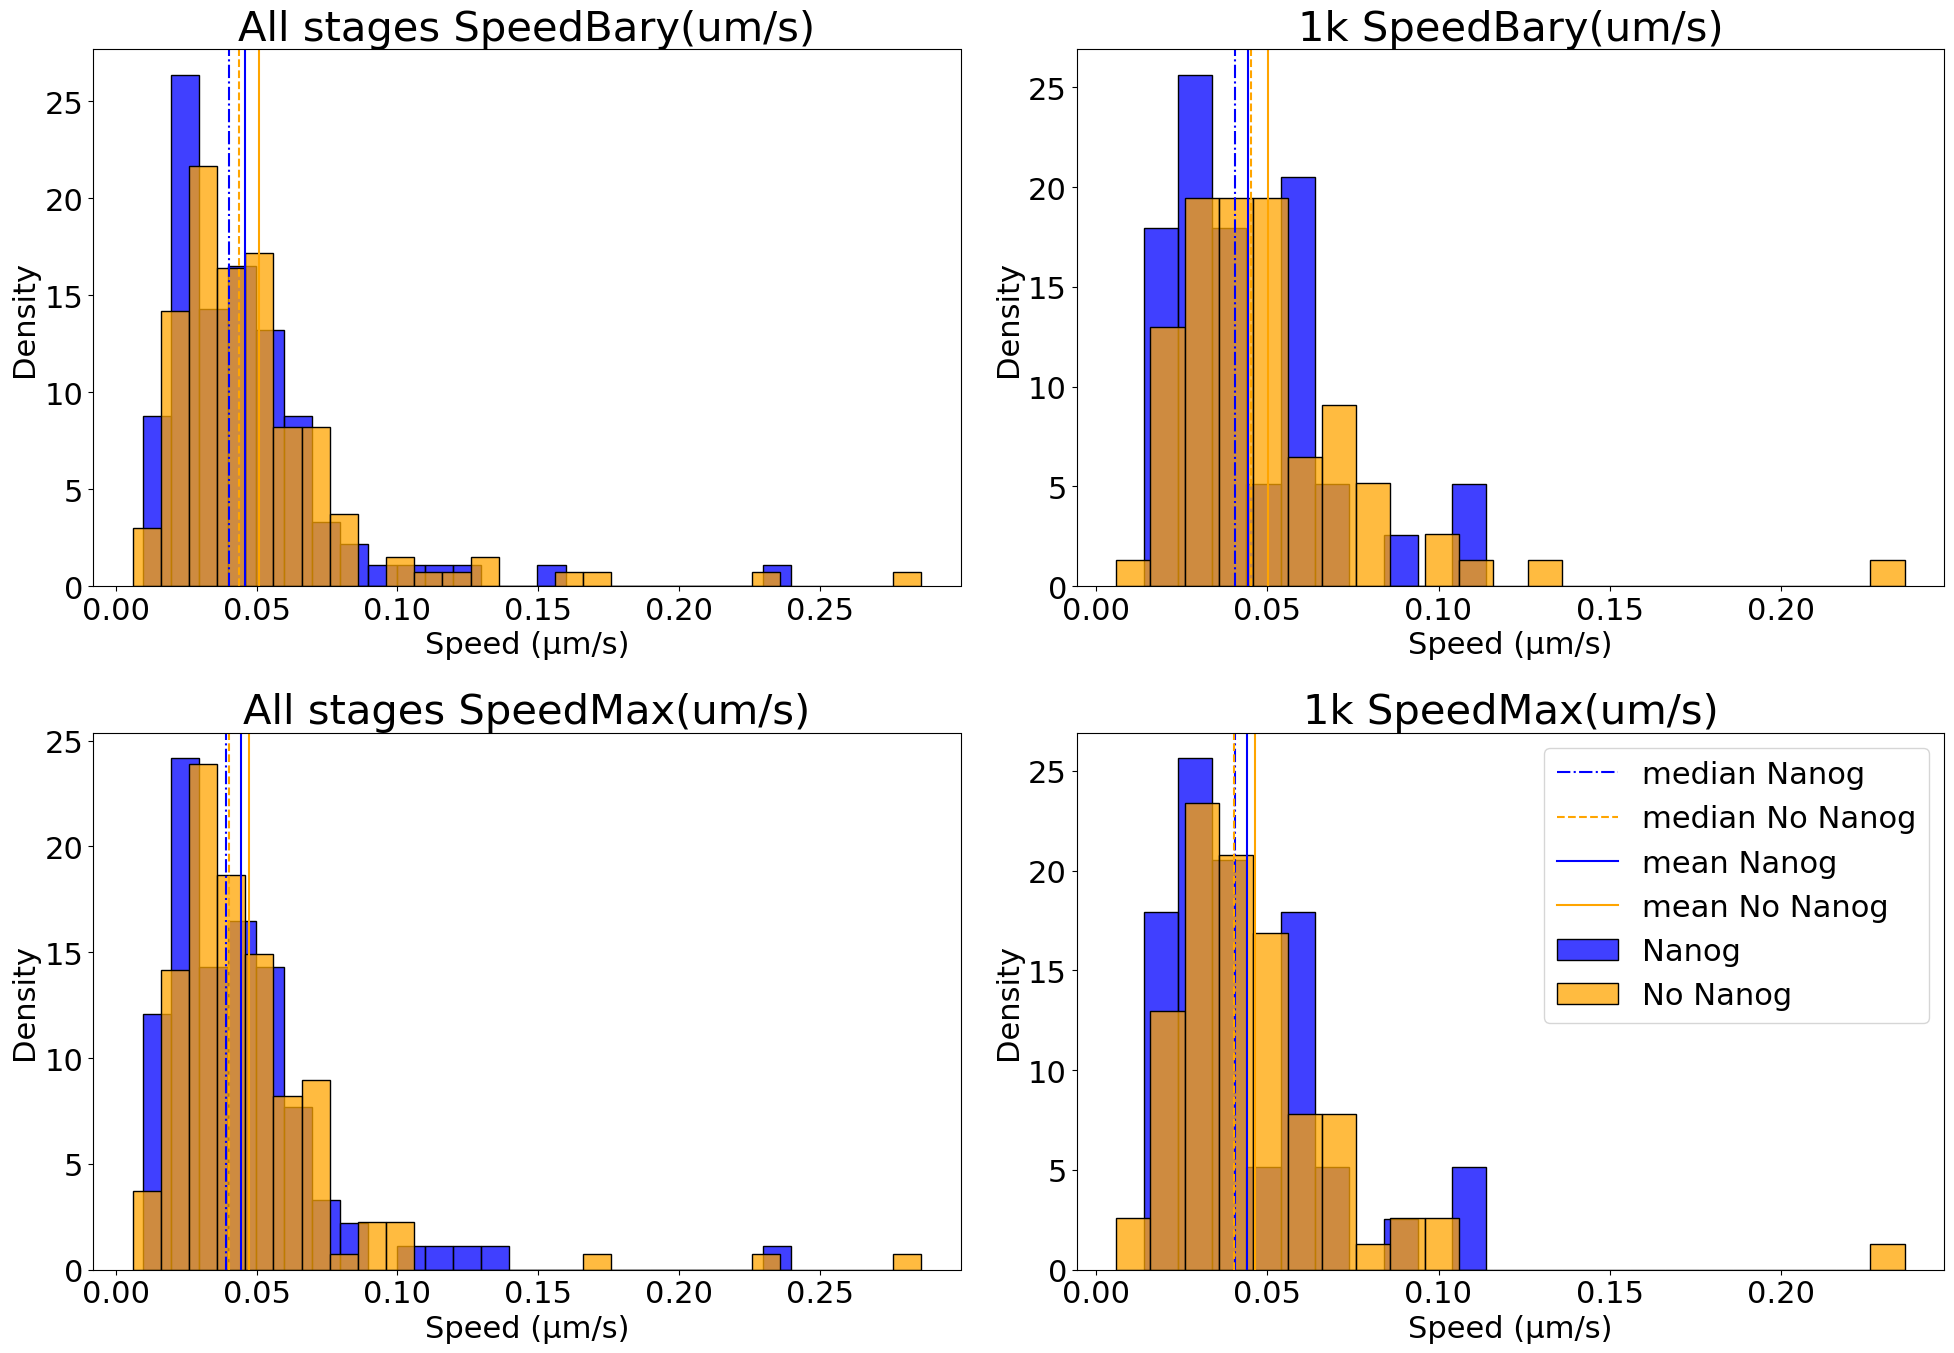

In [38]:
fig, axs = plt.subplots(ncols=len(stages_to_check),nrows=len(speed_metrics_to_check),figsize=(10*len(stages_to_check),7*len(dist_metrics_to_check)))

i = 0
for speed_metric in speed_metrics_to_check:
    j=0
    for stage in stages_to_check:

        # Get speeds to come together from max distance
        v_nanog = dict_nanog[stage][speed_metric]
        v_no_nanog = dict_no_nanog[stage][speed_metric]

        # Statistical test
        U1, p_mw = stats.mannwhitneyu(v_nanog,v_no_nanog,alternative="greater")
        print("p-value Mann-Whitney U test: %f"%p_mw)
        stats_table = stats_table.append({'Measure' : "speed to come together from max", 'Metric' : speed_metric,'Stage' : stage, 'p-value':p_mw},ignore_index=True)

        sns.histplot(ax=axs[i,j], data=pd.DataFrame({"nanog":v_nanog})["nanog"],stat="density",color="blue",label="Nanog",binwidth=0.01)
        sns.histplot(ax=axs[i,j], data=pd.DataFrame({"no nanog":v_no_nanog})["no nanog"],stat="density",color="orange",label = "No Nanog",binwidth=0.01)
        axs[i,j].set_title(stage + " " + speed_metric, fontsize=30)
        axs[i,j].axvline(x=np.median(v_nanog),color="blue",linestyle='-.',label="median Nanog")
        axs[i,j].axvline(x=np.median(v_no_nanog),color="orange",linestyle='--',label="median No Nanog")
        axs[i,j].axvline(x=np.mean(v_nanog),color="blue",linestyle='-',label="mean Nanog")
        axs[i,j].axvline(x=np.mean(v_no_nanog),color="orange",linestyle='-',label="mean No Nanog")
        axs[i,j].set_xlabel("Speed (µm/s)")
        
        j+=1
    i+=1
axs[i-1,j-1].legend()
plt.tight_layout()
plt.show()

## 5.3 Hypothesis test for "glue hypothesis" - 1k and full dataset

### Time in consensed state including flat lines

p-value Mann-Whitney U test: 0.000076
p-value Mann-Whitney U test: 0.000076


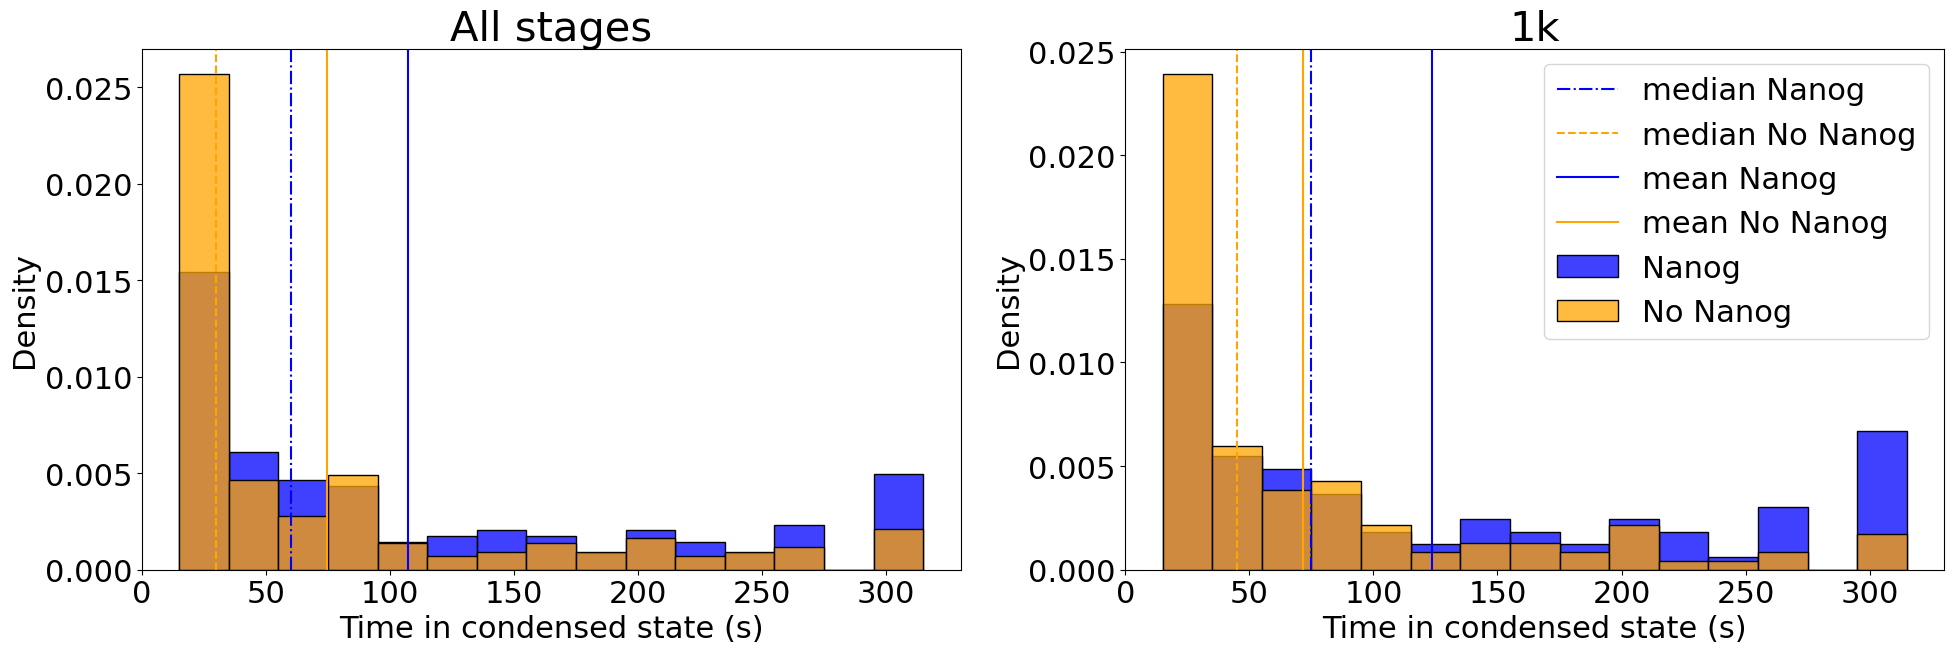

In [39]:
fig, ax = plt.subplots(ncols=len(stages_to_check),nrows=1,figsize=(10*len(stages_to_check),7))

i = 0
for stage in stages_to_check:

    # Get times sticked
    tau_stick_nanog = dict_nanog[stage]["TimeCondensedState(s)-IncludingFlat"]
    tau_stick_no_nanog = dict_no_nanog[stage]["TimeCondensedState(s)-IncludingFlat"]

    # Statistical test
    U1, p_mw = stats.mannwhitneyu(tau_stick_nanog,tau_stick_no_nanog,alternative="greater")
    print("p-value Mann-Whitney U test: %f"%p_mw)
    stats_table = stats_table.append({'Measure' : "time in condensed state - including flat", 'Metric' : "-" ,'Stage' : stage, 'p-value':p_mw},ignore_index=True)

    # Plot histograms
    ax[i].set_title(stage, fontsize=30)
    sns.histplot(ax=ax[i],data=pd.DataFrame({"nanog":tau_stick_nanog})["nanog"],stat="density",color="blue",label="Nanog",binwidth=20)
    sns.histplot(ax=ax[i],data=pd.DataFrame({"no nanog":tau_stick_no_nanog})["no nanog"],stat="density",color="orange",label = "No Nanog",binwidth=20)
    ax[i].set_xlabel("Time in condensed state (s)")
    ax[i].axvline(x=np.median(tau_stick_nanog),color="blue",linestyle='-.',label="median Nanog")
    ax[i].axvline(x=np.median(tau_stick_no_nanog),color="orange",linestyle='--',label="median No Nanog")
    ax[i].axvline(x=np.mean(tau_stick_nanog),color="blue",linestyle='-',label="mean Nanog")
    ax[i].axvline(x=np.mean(tau_stick_no_nanog),color="orange",linestyle='-',label="mean No Nanog")
    i+=1
ax[i-1].legend()
plt.tight_layout()
plt.show()

### Time in condensed state excluding flat lines

p-value Mann-Whitney U test: 0.000088
p-value Mann-Whitney U test: 0.000029


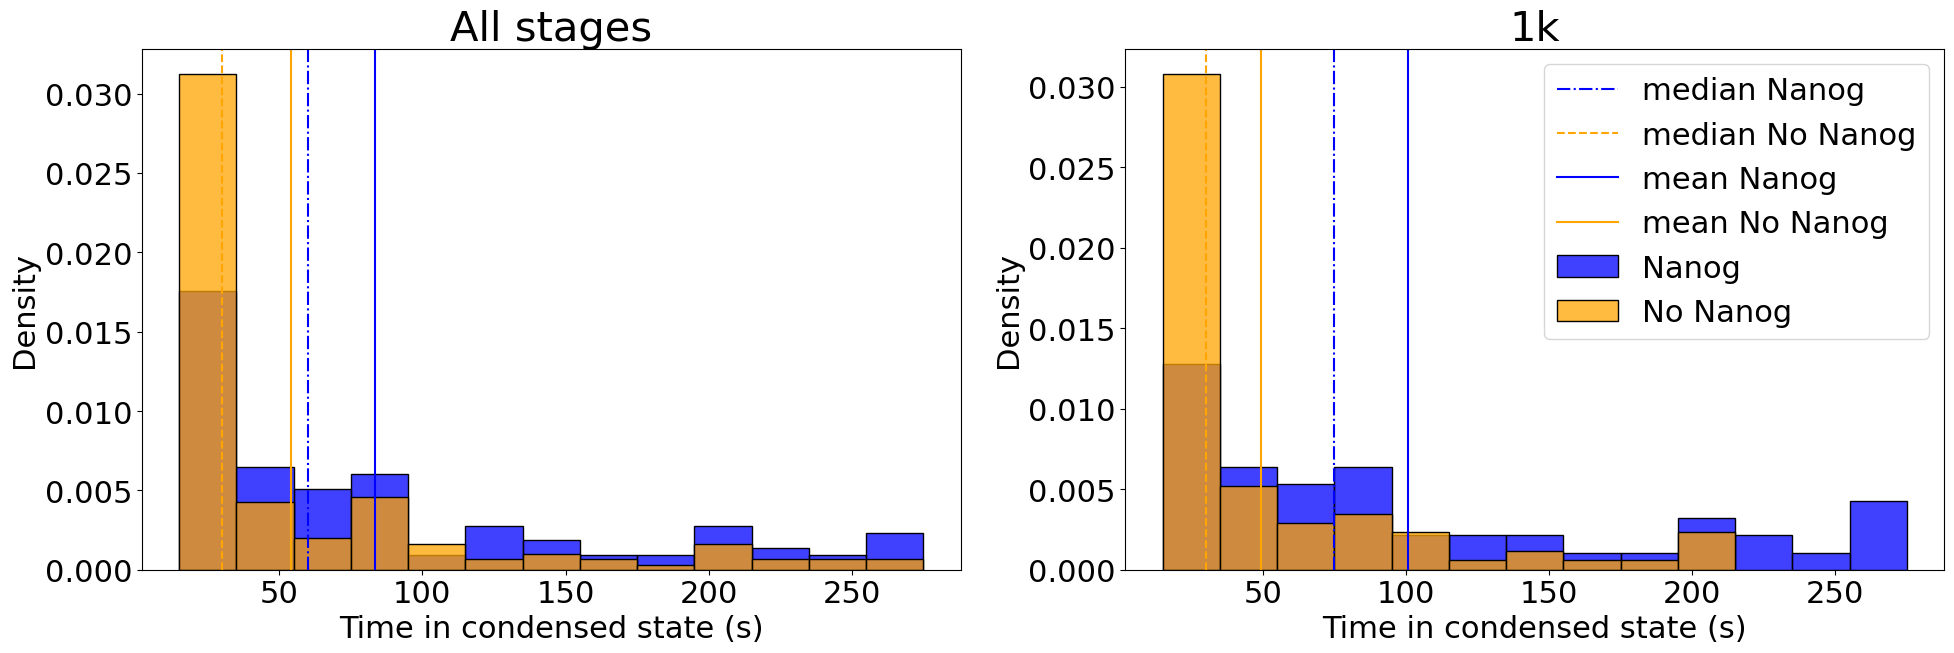

In [40]:
fig, ax = plt.subplots(ncols=len(stages_to_check),nrows=1,figsize=(10*len(stages_to_check),7))

i = 0
for stage in stages_to_check:

    # Get times sticked
    tau_stick_nanog = dict_nanog[stage]["TimeCondensedState(s)-ExcludingFlat"]
    tau_stick_no_nanog = dict_no_nanog[stage]["TimeCondensedState(s)-ExcludingFlat"]

    # Statistical test
    U1, p_mw = stats.mannwhitneyu(tau_stick_nanog,tau_stick_no_nanog,alternative="greater")
    print("p-value Mann-Whitney U test: %f"%p_mw)
    stats_table = stats_table.append({'Measure' : "time in condensed state - excluding flat", 'Metric' : "-" ,'Stage' : stage, 'p-value':p_mw},ignore_index=True)

    # Plot histograms
    ax[i].set_title(stage, fontsize=30)
    sns.histplot(ax=ax[i],data=pd.DataFrame({"nanog":tau_stick_nanog})["nanog"],stat="density",color="blue",label="Nanog",binwidth=20)
    sns.histplot(ax=ax[i],data=pd.DataFrame({"no nanog":tau_stick_no_nanog})["no nanog"],stat="density",color="orange",label = "No Nanog",binwidth=20)
    ax[i].set_xlabel("Time in condensed state (s)")
    ax[i].axvline(x=np.median(tau_stick_nanog),color="blue",linestyle='-.',label="median Nanog")
    ax[i].axvline(x=np.median(tau_stick_no_nanog),color="orange",linestyle='--',label="median No Nanog")
    ax[i].axvline(x=np.mean(tau_stick_nanog),color="blue",linestyle='-',label="mean Nanog")
    ax[i].axvline(x=np.mean(tau_stick_no_nanog),color="orange",linestyle='-',label="mean No Nanog")
    i+=1
ax[i-1].legend()
plt.tight_layout()
plt.show()

## Save p-values to file

In [41]:
stats_table.to_csv(today+"-hp_tests.csv",index=True,sep='\t')

# 6. Distribution of time sticked - is the number of flat lines consistent? 

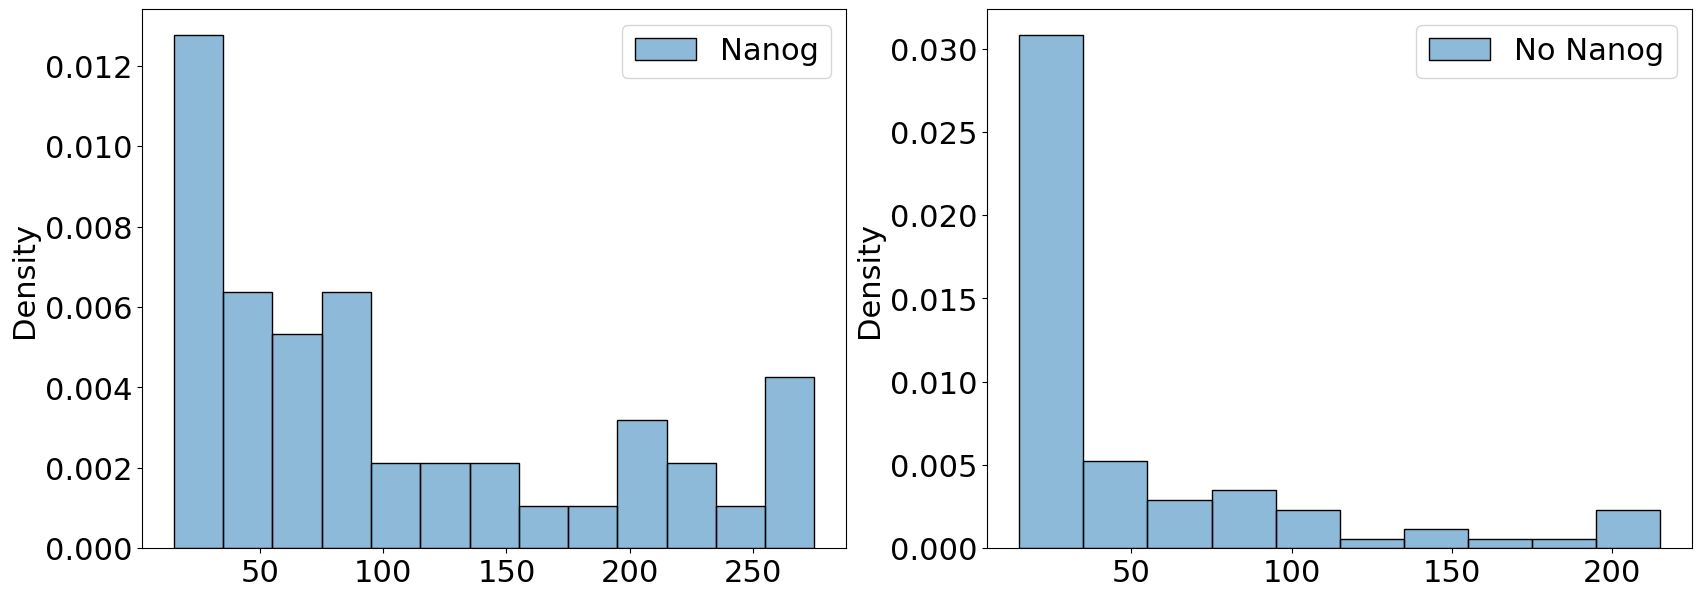

In [42]:
# Plot histograms of time sticked for Nanog and No Nanog conditions

fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(20,7))
sns.histplot(ax=axs[0], data=pd.DataFrame(tau_stick_nanog),stat="density",bins=15,color="blue",label="Nanog",binwidth=20)
sns.histplot(ax=axs[1], data=pd.DataFrame(tau_stick_no_nanog),stat="density",bins=15,color="blue",label="No Nanog",binwidth=20)
axs[0].legend()
axs[1].legend()
plt.show()

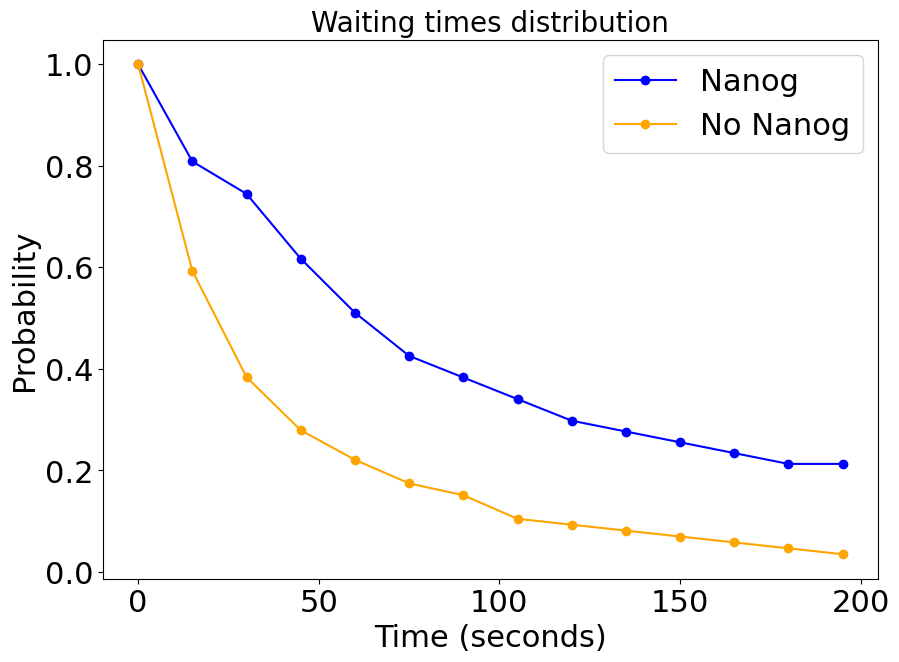

In [43]:
# Calculate waiting times probabilities

dt = 15
waiting_times = np.arange(0,200,dt)
waiting_times_prob_nanog = np.zeros(len(waiting_times))
waiting_times_prob_no_nanog = np.zeros(len(waiting_times))
for i in range(len(waiting_times)):
    waiting_times_prob_nanog[i] = np.sum(tau_stick_nanog>waiting_times[i])/len(tau_stick_nanog)
    waiting_times_prob_no_nanog[i] = np.sum(tau_stick_no_nanog>waiting_times[i])/len(tau_stick_no_nanog)

# plot distribution of waiting times
fig, axs = plt.subplots(ncols=1,nrows=1,figsize=(10,7))
# set title
axs.set_title("Waiting times distribution", fontsize=20)
axs.plot(waiting_times,waiting_times_prob_nanog,'-o',color="blue",label="Nanog")
axs.plot(waiting_times,waiting_times_prob_no_nanog,'-o',color="orange",label="No Nanog")
axs.set_xlabel("Time (seconds)")
axs.set_ylabel("Probability")
axs.legend()   
plt.show()

In [44]:
# Fit a slope to waiting time distribution

slope_nanog, intercept_nanog, r_nanog, p_nanog, se_nanog = stats.linregress(waiting_times, -np.log(waiting_times_prob_nanog))
slope_no_nanog, intercept_no_nanog, r_no_nanog, p_no_nanog, se_no_nanog = stats.linregress(waiting_times, -np.log(waiting_times_prob_no_nanog))

print(slope_nanog)
print(slope_no_nanog)

0.008153912665036959
0.015466561372064124


In [45]:
# Actually, the intercept can be fixed to 1. We can calculate the intercept with the leat squares fit

slope_nanog_ls = np.cov(-np.log(waiting_times_prob_nanog),waiting_times)[0][1]/np.cov(-np.log(waiting_times_prob_nanog),waiting_times)[1][1]
print(slope_nanog_ls)

0.008153912665036959


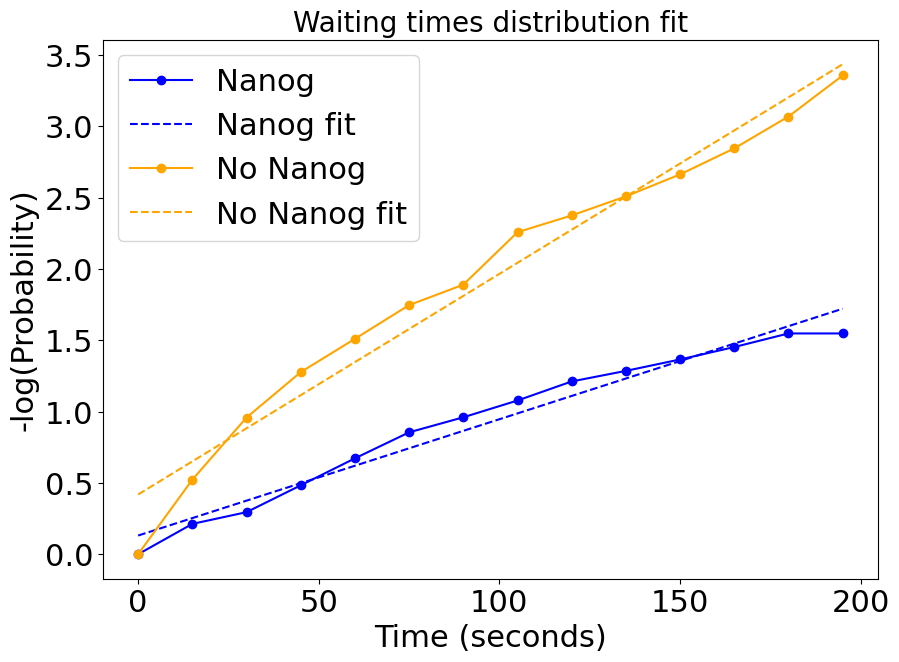

In [46]:
# plot distribution of waiting times with fit
fig, axs = plt.subplots(ncols=1,nrows=1,figsize=(10,7))
# set title
axs.set_title("Waiting times distribution fit", fontsize=20)
axs.plot(waiting_times,-np.log(waiting_times_prob_nanog),'-o',color="blue",label="Nanog")
axs.plot(waiting_times,intercept_nanog + slope_nanog*waiting_times,'--',color="blue",label="Nanog fit")
axs.plot(waiting_times,-np.log(waiting_times_prob_no_nanog),'-o',color="orange",label="No Nanog")
axs.plot(waiting_times,intercept_no_nanog + slope_no_nanog*waiting_times,'--',color="orange",label="No Nanog fit")
axs.set_xlabel("Time (seconds)")
axs.set_ylabel("-log(Probability)")
axs.legend()
#plt.savefig('waiting_times_fit.pdf')   
plt.show()

In [47]:
# Calculate the probability of waiting more than 300s

p_wait_nanog = np.exp(-intercept_nanog -slope_nanog*300)
p_wait_no_nanog = np.exp(-intercept_no_nanog -slope_no_nanog*300)

print(p_wait_nanog)
print(p_wait_no_nanog)

0.07599457892347206
0.006353854733145175


In [48]:
summary_table["Tracks always sticked"]

0     0.304878
1     0.185185
2     0.340909
3     0.170732
4     0.230769
5     0.090909
6        0.125
7     0.222222
8          0.5
9          NaN
10    0.222222
11         0.5
Name: Tracks always sticked, dtype: object

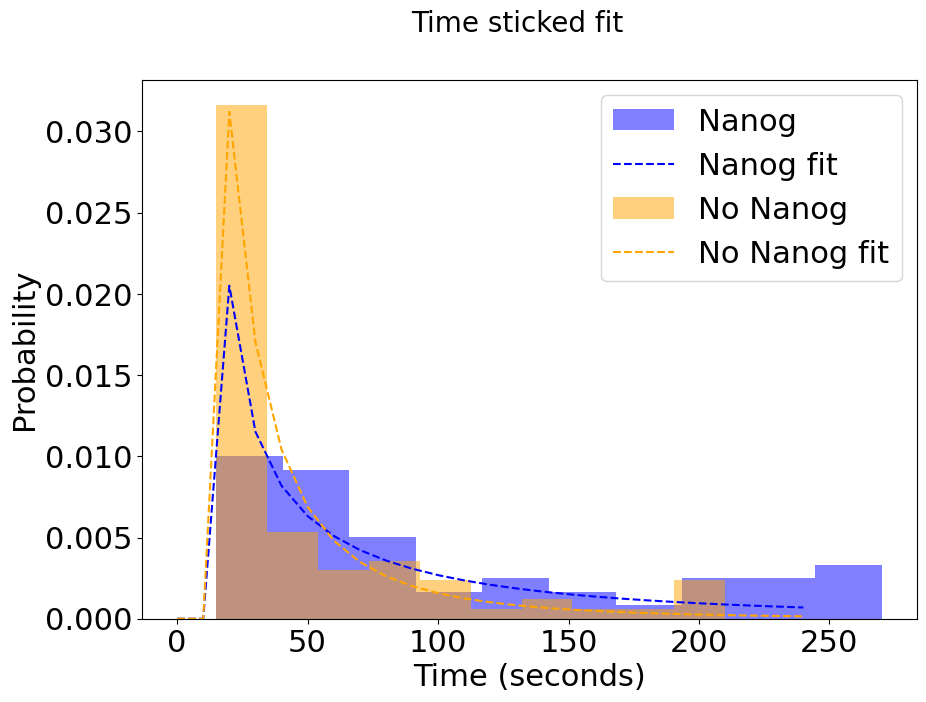

In [49]:
# Fit a generalized gamma distribution to the inverse log of waiting_times_prob_nanog 

a_nanog, c_nanog, loc_nanog, scale_nanog = stats.gengamma.fit(tau_stick_nanog)
a_no_nanog, c_no_nanog, loc_no_nanog, scale_no_nanog = stats.gengamma.fit(tau_stick_no_nanog)

# plot distribution of waiting times with fit
fig, axs = plt.subplots(ncols=1,nrows=1,figsize=(10,7))
plt.suptitle("Time sticked fit", fontsize=20)
axs.hist(tau_stick_nanog,color="blue",label="Nanog",density=True,alpha=0.5)
times = np.arange(0,250,10)
axs.plot(times,stats.gengamma.pdf(times,a_nanog,c_nanog,loc_nanog,scale_nanog),'--',color="blue",label="Nanog fit")
axs.hist(tau_stick_no_nanog,color="orange",label="No Nanog",density=True,alpha=0.5)
axs.plot(times,stats.gengamma.pdf(times,a_no_nanog,c_no_nanog,loc_no_nanog,scale_no_nanog),'--',color="orange",label="No Nanog fit")
axs.set_xlabel("Time (seconds)")
axs.set_xlabel("Time (seconds)")
axs.set_ylabel("Probability")
axs.legend()   
#plt.savefig('time_sticked_fit.pdf')
plt.show()

In [50]:
# Calculate probability of time sticked more than 300

p_wait_nanog = 1-stats.gengamma.cdf(300,a_nanog,c_nanog,loc_nanog,scale_nanog)
p_wait_no_nanog = 1-stats.gengamma.cdf(300,a_no_nanog,c_no_nanog,loc_no_nanog,scale_no_nanog)

print(p_wait_nanog)
print(p_wait_no_nanog)

0.09203165118988599
0.008599735804140085
